# Проект: Прогнозирование температуры стали в процессе обработки

 Описание проекта

Металлургический комбинат «Стальная птица» хочет оптимизировать производственные расходы, уменьшив потребление электроэнергии на этапе обработки стали. Для этого нужно контролировать температуру металлического сплава.

Цель проекта - построить модель машинного обучения, которая будет предсказывать температуру стали на основе различных параметров производственного процесса. Заказчик планирует использовать модель для имитации технологического процесса.

 Описание процесса обработки стали

1. Расплавленную сталь заливают в металлический ковш вместимостью около 100 тонн, облицованный огнеупорным кирпичом. 
2. Сталь подогревают до нужной температуры графитовыми электродами, установленными на крышке ковша.
3. Сначала проводится десульфурация - удаление серы и корректировка химсостава добавками. 
4. Затем сталь легируют - добавляют сплавы в виде кусков из бункера или порошковой проволоки через трайб-аппарат.
5. Перед первым легированием проводят химанализ и измерение температуры, потом на несколько минут повышают температуру, добавляют легирующие, продувают инертным газом для перемешивания и повторно анализируют. Цикл повторяется до достижения нужного химсостава и температуры.
6. Готовая сталь отправляется на доводку или в машину непрерывной разливки для формирования слябов.

 Описание данных

Данные хранятся в формате SQLite в нескольких таблицах:
- steel.data_arc — данные об электродах
- steel.data_bulk — данные об объёме сыпучих материалов
- steel.data_bulk_time — данные о времени подачи сыпучих материалов  
- steel.data_gas — данные о продувке сплава газом
- steel.data_temp — данные об измерениях температуры
- steel.data_wire — данные об объёме проволочных материалов
- steel.data_wire_time — данные о времени подачи проволочных материалов

Номер партии содержится в столбце key всех таблиц. Для одной партии может быть несколько строк, соответствующих разным итерациям обработки.

 Инструкция по выполнению

1. Загрузить данные из SQLite.

2. Провести исследовательский анализ и предобработку данных:
- Проверить наличие пропусков, аномалий, изучить распределения признаков
- Обработать аномалии и пропуски 
- Сгенерировать новые признаки
- Объединить таблицы по ключу партии
- Визуализировать распределения признаков
- Провести корреляционный анализ  
- Подготовить выборки для обучения моделей

3. Обучить модели прогнозирования температуры:
- Деревья решений / случайный лес
- Бустинги 
- Нейронные сети  
- Подобрать гиперпараметры, найти лучшую модель по MAE на кросс-валидации

4. Протестировать лучшую модель на тестовой выборке:
- MAE < 6.8
- Сравнить с константной моделью
- Проанализировать важность признаков 

5. Сделать выводы по работе:
- Предложения по улучшению модели
- Бизнес-рекомендации заказчику

 Дополнительные замечания 

- Заказчик предупредил о наличии аномалий температуры ниже 1500 и возможной асинхронности временных меток датчиков.

- При агрегации наблюдений температуры по партии использовать только первый/последний замеры.

- Значение константы RANDOM_STATE = дата начала проекта (пример: 10922 для 1 сентября 2022). Использовать для разбиения на выборки.


# Шаг 1. Загрузите данные

In [1]:
!pip install optuna
!pip install lightgbm

In [2]:
# Стандартные библиотеки Python
import os
from datetime import datetime

# Библиотеки для работы с данными и математических вычислений
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Библиотеки для предобработки данных
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import optuna

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Библиотеки для работы с Jupyter Notebook
from IPython.display import display

# Импортируем библиотеку для работы с HTTP-запросами
import requests  


In [3]:
# Загрузка файла базы данных
!curl -O https://code.s3.yandex.net/data-scientist/ds-plus-final.db

/bin/bash: curl: command not found


In [4]:
# Функция для загрузки базы данных, если она нужна
def download_database(filename, url):
    if os.path.exists(filename):  # Проверяем существование файла
        os.remove(filename)  # Удаляем существующий файл во избежание повреждения
    response = requests.get(url)  # Делаем GET-запрос по URL
    with open(filename, "wb") as file:  # Открываем файл в режиме записи байтов
        file.write(response.content)  # Записываем содержимое ответа в файл
    display(f"Файл {filename} успешно скачан.")  # Выводим сообщение об успешной загрузке

# Детали базы данных
filename = "ds-plus-final.db"  # Имя файла базы данных
url = "https://code.s3.yandex.net/data-scientist/ds-plus-final.db"  # URL для загрузки
path_to_db = filename  # Путь к базе данных

# Проверяем существование файла базы данных, скачиваем если его нет
if not os.path.exists(path_to_db):
    display(f"Файл базы данных {filename} не найден. Скачивание...")
    download_database(filename, url)

# Подключаемся к базе данных
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)  # Создаем соединение с базой данных

# Путь к файлу базы данных
path_to_db = 'ds-plus-final.db'

# Создание подключения к базе данных
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)
# Получим список всех таблиц в базе данных


In [5]:
RANDOM_STATE = 210425  # Используем 21 апреля 2025 года как RANDOM_STATE

## Шаг 2.0 Cписок всех таблиц в базе данных

In [6]:
# Получим список всех таблиц в базе данных
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", engine)
display(tables)

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


В базе данных содержится 11 таблиц, включая таблицы с данными о контрактах, персональных данных, телефонных номерах, интернете, а также различные таблицы с данными.

## Шаг 2.1 Инициализируем переменную data_arc 

In [7]:
# Допустим, одна из таблиц называется "data_arc"
data_arc = pd.read_sql("SELECT * FROM data_arc", engine)
data_arc.info()
data_arc.describe().transpose()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


### Шаг 2.1.1 Проверка data_arc на пропуски в данных

In [8]:
# Проверка на пропуски в данных
null_counts = data_arc.isnull().sum()
null_percentages = null_counts / len(data_arc) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0


### Шаг 2.1.2 Визуализация data_arc на пропуски в данных

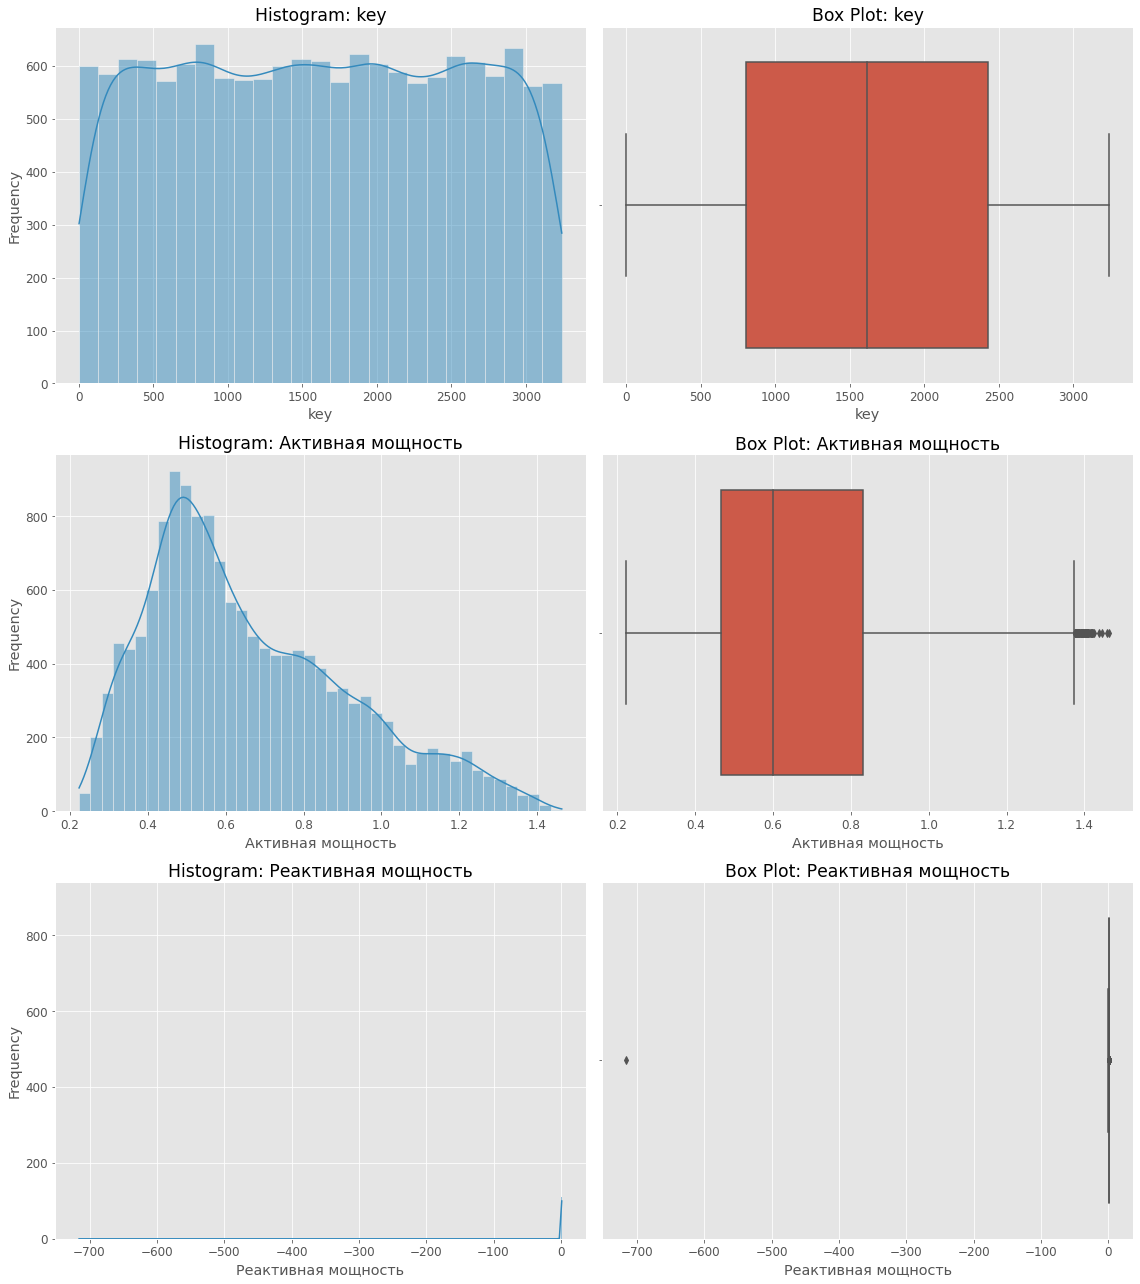

"Cannot convert column arc_heating_start to datetime: 'arc_heating_start'"

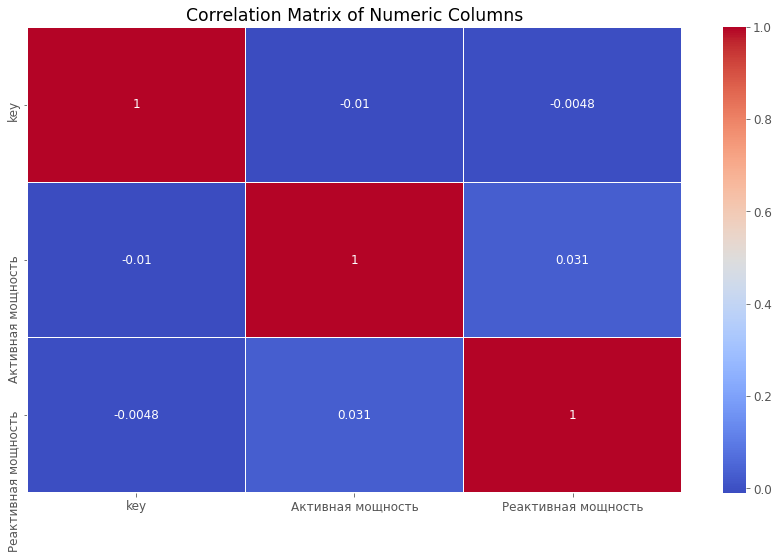

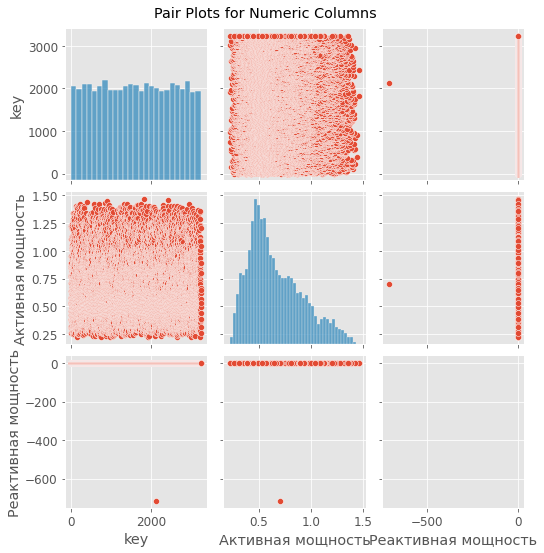

"Cannot convert arc_heating_start to datetime: 'arc_heating_start'"

In [9]:
# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
    
    # Если только один числовой столбец, преобразуем axes в список
    if len(numeric_columns) == 1:
        axes = [axes]
    
    for i, column in enumerate(numeric_columns):
        # Гистограмма
        sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
        axes[i][0].set_title(f'Histogram: {column}')
        axes[i][0].set_xlabel(column)
        axes[i][0].set_ylabel('Frequency')
        
        # Box plot
        sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
        axes[i][1].set_title(f'Box Plot: {column}')
        axes[i][1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

# Функция для визуализации временных данных
def visualize_datetime_columns(df):
    date_columns = ['arc_heating_start', 'arc_heating_end']
    
    df_temp = df.copy()
    for col in date_columns:
        try:
            df_temp[col] = pd.to_datetime(df[col])
        except Exception as e:
            display(f"Cannot convert column {col} to datetime: {e}")
            return
    
    # Вычисляем продолжительность нагрева
    df_temp['heating_duration_minutes'] = (df_temp['arc_heating_end'] - df_temp['arc_heating_start']).dt.total_seconds() / 60
    
    # Распределение продолжительности нагрева
    plt.figure(figsize=(14, 6))
    sns.histplot(df_temp['heating_duration_minutes'].dropna(), kde=True)
    plt.title('Distribution of Arc Heating Duration (Minutes)')
    plt.xlabel('Duration (Minutes)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Распределение по часам суток
    plt.figure(figsize=(14, 6))
    df_temp['start_hour'] = df_temp['arc_heating_start'].dt.hour
    sns.countplot(x='start_hour', data=df_temp)
    plt.title('Distribution of Arc Heating Start by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.xticks(range(0, 24))
    plt.show()
    
    # Распределение по дням недели
    plt.figure(figsize=(14, 6))
    df_temp['day_of_week'] = df_temp['arc_heating_start'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.countplot(x='day_of_week', data=df_temp, order=day_order)
    plt.title('Distribution of Arc Heating by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Функция для анализа корреляций
def visualize_correlations(df):
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Numeric Columns')
    plt.tight_layout()
    plt.show()
    
    sns.pairplot(numeric_df)
    plt.suptitle('Pair Plots for Numeric Columns', y=1.02)
    plt.show()

# Функция для визуализации временных рядов мощности
def visualize_power_time_series(df):
    df_temp = df.copy()
    try:
        df_temp['arc_heating_start'] = pd.to_datetime(df['arc_heating_start'])
    except Exception as e:
        display(f"Cannot convert arc_heating_start to datetime: {e}")
        return
    
    df_temp = df_temp.sort_values('arc_heating_start')
    
    # Временной ряд активной и реактивной мощности
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    color = 'tab:red'
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Active Power', color=color)
    ax1.plot(df_temp['arc_heating_start'], df_temp['active_power'], color=color, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Reactive Power', color=color)
    ax2.plot(df_temp['arc_heating_start'], df_temp['reactive_power'], color=color, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Time Series of Active and Reactive Power')
    plt.tight_layout()
    plt.show()
    
    # Скользящие средние для активной мощности
    plt.figure(figsize=(16, 8))
    df_temp.set_index('arc_heating_start', inplace=True)
    rolling_windows = [10, 50, 100]
    
    plt.plot(df_temp.index, df_temp['active_power'], label='Original Data', alpha=0.4)
    
    for window in rolling_windows:
        plt.plot(df_temp.index, df_temp['active_power'].rolling(window=window).mean(), 
                 label=f'Rolling Mean {window}')
    
    plt.title('Rolling Means for Active Power')
    plt.xlabel('Date and Time')
    plt.ylabel('Active Power')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Вызов функций для визуализации
try:
    visualize_numeric_columns(data_arc)
    visualize_datetime_columns(data_arc)
    visualize_correlations(data_arc)
    visualize_power_time_series(data_arc)
except Exception as e:
    display(f"Error during visualization: {e}")

### Шаг 2.1.3 Переименование столбцов data_arc в snake_case формат на более удобные английские названия

In [10]:
# Переименование столбцов на более удобные английские названия
data_arc = data_arc.rename(columns={
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_end',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

# Проверка результата переименования
display("Новые названия столбцов:")
display(data_arc.columns.tolist())

# Просмотр первых нескольких строк с новыми названиями
display("Просмотр данных:")
display(data_arc.head())

# Проверка информации о таблице
display("Информация о таблице:")
data_arc.info()

'Новые названия столбцов:'

['key',
 'arc_heating_start',
 'arc_heating_end',
 'active_power',
 'reactive_power']

'Просмотр данных:'

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


'Информация о таблице:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14876 non-null  int64  
 1   arc_heating_start  14876 non-null  object 
 2   arc_heating_end    14876 non-null  object 
 3   active_power       14876 non-null  float64
 4   reactive_power     14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


### Шаг 2.1.4 Заменяем значения меньше -100 на медиану

'Медиана reactive_power: 0.44163949999999996'

'Статистика reactive_power после замены:'

count    14876.000000
mean         0.487112
std          0.197606
min          0.153777
25%          0.337192
50%          0.441652
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

'Проверка наличия значений < -100:'

,key,arc_heating_start,arc_heating_end,active_power,reactive_power


'Информация о таблице после замены:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14876 non-null  int64  
 1   arc_heating_start  14876 non-null  object 
 2   arc_heating_end    14876 non-null  object 
 3   active_power       14876 non-null  float64
 4   reactive_power     14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


'Просмотр нескольких строк:'

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


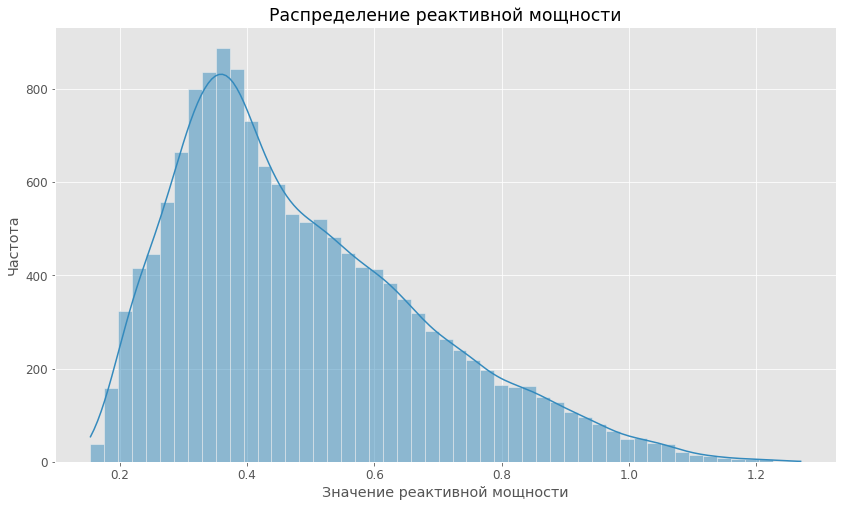

In [11]:

# Находим медиану для reactive_power
median_value = data_arc['reactive_power'].median()

# Заменяем значения меньше 100 на медиану
data_arc.loc[data_arc['reactive_power'] < -100, 'reactive_power'] = median_value

# Проверка результата
display(f"Медиана reactive_power: {median_value}")
display("Статистика reactive_power после замены:")
display(data_arc['reactive_power'].describe())

# Дополнительно проверяем, что замены произошли корректно
display("Проверка наличия значений < -100:")
display(data_arc[data_arc['reactive_power'] < -100])

# Просмотр обновленных данных
display("Информация о таблице после замены:")
data_arc.info()

display("Просмотр нескольких строк:")
display(data_arc.head())



# Гистограмма распределения
sns.histplot(data=data_arc['reactive_power'], kde=True)
plt.title('Распределение реактивной мощности')
plt.xlabel('Значение реактивной мощности')
plt.ylabel('Частота')
plt.show()

In [12]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14876 non-null  int64  
 1   arc_heating_start  14876 non-null  object 
 2   arc_heating_end    14876 non-null  object 
 3   active_power       14876 non-null  float64
 4   reactive_power     14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


### Шаг 2.1.5 Преобразование столбцов с датами и временем в формат datetime

In [13]:
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start']) 
data_arc['arc_heating_end'] = pd.to_datetime(data_arc['arc_heating_end'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [14]:
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 
                                     + data_arc['reactive_power']**2)

### Шаг 2.1.7 Вычисление общего времени нагрева дугой в секундах

### Шаг 2.1.6 Вычисление полной (кажущейся) мощности

In [15]:
data_arc['arc_heating_time'] = (
    data_arc['arc_heating_end'] - data_arc['arc_heating_start']).dt.seconds


### Шаг 2.1.8 Подсчет количества раундов нагрева для каждого ключа

In [16]:
# Подсчет количества раундов нагрева для каждого ключа
#heating_rounds = data_arc.groupby('key').size().reset_index(name='heating_rounds')
heating_rounds = data_arc.groupby('key').size().reset_index(name='heating_rounds')
heating_rounds.head()



,key,heating_rounds
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


In [17]:
data_arc.info()


# Агрегация только числовых столбцов
data_arc = data_arc.groupby(by='key')[['active_power', 'reactive_power', 'apparent_power', 'arc_heating_time']].sum().reset_index()

# Объединение с heating_rounds
data_arc = data_arc.merge(heating_rounds, on='key')

# Вывод результатов
data_arc.head()
data_arc.info()

data_arc.head()
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
 5   apparent_power     14876 non-null  float64       
 6   arc_heating_time   14876 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 813.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   active_power      3214 non-null   float64
 2   reactive_power    3214 non-

Мы проанализировали таблицу data_arc: визуализировали длительность нагрева, распределение по времени суток и дням недели, а также построили корреляционную матрицу.

## Шаг 2.2 Инициализируем переменную data_bulk 

In [18]:
# Допустим, одна из таблиц называется "data_bulk"
data_bulk = pd.read_sql("SELECT * FROM data_bulk", engine)
data_bulk.info()
data_bulk.describe().transpose()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


### Шаг 2.2.1 Проверка data_bulk на пропуски в данных

In [19]:
# Проверка на пропуски в данных
null_counts = data_bulk.isnull().sum()
null_percentages = null_counts / len(data_bulk) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
Bulk 1,2877,91.946309
Bulk 2,3107,99.296900
Bulk 3,1831,58.517098
Bulk 4,2115,67.593480
Bulk 5,3052,97.539150
Bulk 6,2553,81.591563
Bulk 7,3104,99.201023
Bulk 8,3128,99.968041
Bulk 9,3110,99.392777


### Шаг 2.2.2 Визуализация data_bulk на пропуски в данных

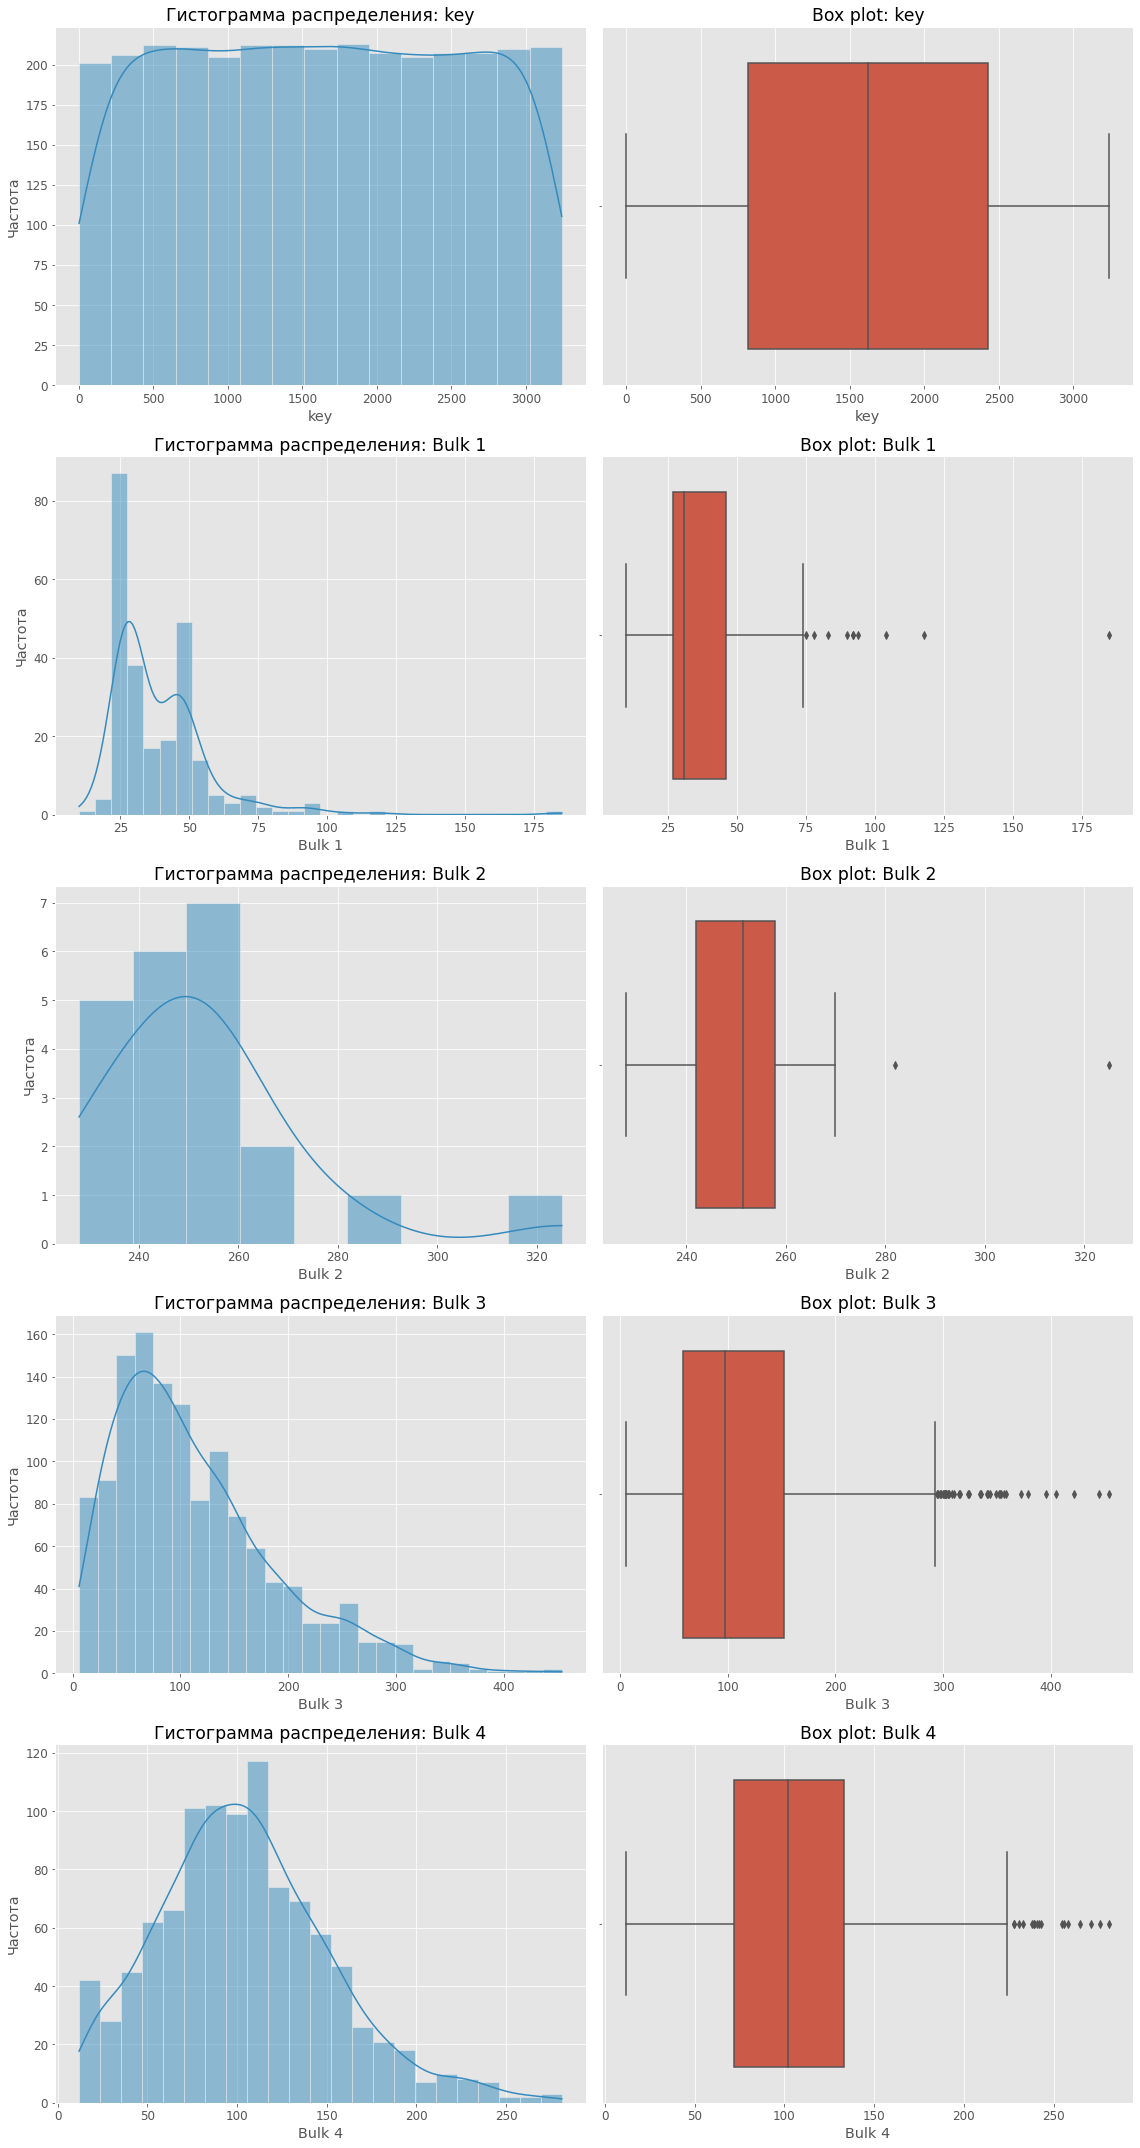

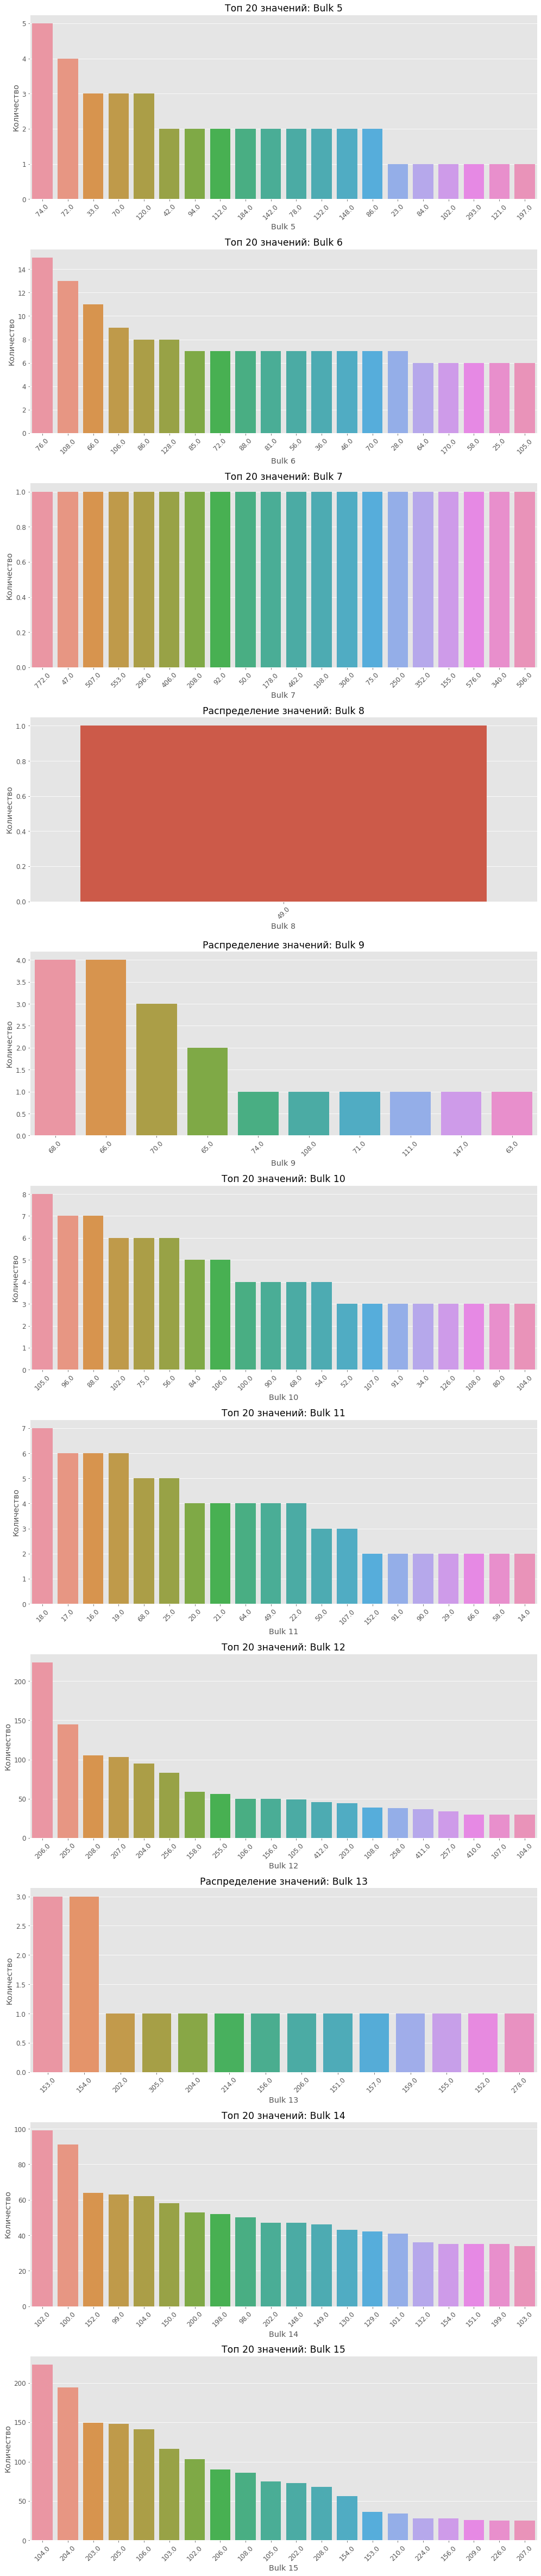

In [20]:
# Предполагаем, что data_bulk уже загружен
# data_bulk = pd.read_sql("SELECT * FROM data_bulk", engine)

# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных (float64, int64)
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
    
    # Если только один числовой столбец, преобразуем axes в список
    if len(numeric_columns) == 1:
        axes = [axes]
    
    for i, column in enumerate(numeric_columns):
        # Гистограмма
        sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
        axes[i][0].set_title(f'Гистограмма распределения: {column}')
        axes[i][0].set_xlabel(column)
        axes[i][0].set_ylabel('Частота')
        
        # Box plot
        sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
        axes[i][1].set_title(f'Box plot: {column}')
        axes[i][1].set_xlabel(column)
        
    plt.tight_layout()
    plt.show()

# Функция для визуализации категориальных данных (object)
def visualize_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    if categorical_columns.size > 0:
        fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(14, 6*len(categorical_columns)))
        
        # Если только один категориальный столбец, преобразуем axes в список
        if len(categorical_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(categorical_columns):
            value_counts = df[column].value_counts().sort_values(ascending=False)
            
            # Ограничиваем количество значений для наглядности
            if len(value_counts) > 20:
                value_counts = value_counts.head(20)
                axes[i].set_title(f'Топ 20 значений: {column}')
            else:
                axes[i].set_title(f'Распределение значений: {column}')
            
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Количество')
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# Вызываем функции для визуализации
visualize_numeric_columns(data_bulk)
visualize_categorical_columns(data_bulk)

### Шаг 2.2.3 Переименование столбцов data_bulk в snake_case формат на более удобные английские названия

In [21]:
# Переименование столбцов в snake_case формат
new_columns = {
    'key': 'key',
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2', 
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'
}

data_bulk = data_bulk.rename(columns=new_columns)

# Проверка пропусков с новыми названиями
null_counts = data_bulk.isnull().sum()
null_percentages = null_counts / len(data_bulk) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))

'Анализ пропусков в данных:'

,количество_пропусков,процент_пропусков
key,0,0.000000
bulk_1,2877,91.946309
bulk_2,3107,99.296900
bulk_3,1831,58.517098
bulk_4,2115,67.593480
bulk_5,3052,97.539150
bulk_6,2553,81.591563
bulk_7,3104,99.201023
bulk_8,3128,99.968041
bulk_9,3110,99.392777


### Шаг 2.2.4 Удаляем столбцы с более чем 50% пропусков. Преобразуем оставшиеся столбцы в тип float64. Заполняем пропуски с помощью KNN Imputation.

In [22]:
# Создаем список столбцов с пропусками менее 50%
columns_to_keep = ['key', 'bulk_12', 'bulk_14', 'bulk_15']

# Фильтруем датасет
data_bulk_filtered = data_bulk[columns_to_keep]

# Преобразуем тип данных столбцов bulk_12, bulk_14, bulk_15 в float64
data_bulk_filtered[['bulk_12', 'bulk_14', 'bulk_15']] = data_bulk_filtered[['bulk_12', 'bulk_14', 'bulk_15']].apply(pd.to_numeric, errors='coerce')

# Заполнение пропусков с помощью KNN Imputation
imputer = KNNImputer(
    n_neighbors=5,
    weights='distance'
)
data_bulk = data_bulk_filtered.copy()
data_bulk.iloc[:, 1:] = imputer.fit_transform(data_bulk.iloc[:, 1:])

# Проверка, что пропуски заполнены
null_counts = data_bulk.isnull().sum()
null_percentages = null_counts / len(data_bulk) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))

# Проверка типов данных
display(data_bulk.info())

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


'Анализ пропусков в данных:'

,количество_пропусков,процент_пропусков
key,0,0.0
bulk_12,0,0.0
bulk_14,0,0.0
bulk_15,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_12  3129 non-null   float64
 2   bulk_14  3129 non-null   float64
 3   bulk_15  3129 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 97.9 KB


None

## Шаг 2.3 Инициализируем переменную data_bulk_time 

In [23]:
# Допустим, одна из таблиц называется "data_bulk_time"
data_bulk_time = pd.read_sql("SELECT * FROM data_bulk_time", engine)
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [24]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [25]:
data_bulk_time.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


### Шаг 2.3.1 Проверка data_bulk_time на пропуски в данных

In [26]:
# Проверка на пропуски в данных
null_counts = data_bulk_time.isnull().sum()
null_percentages = null_counts / len(data_bulk_time) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
Bulk 1,2877,91.946309
Bulk 2,3107,99.296900
Bulk 3,1831,58.517098
Bulk 4,2115,67.593480
Bulk 5,3052,97.539150
Bulk 6,2553,81.591563
Bulk 7,3104,99.201023
Bulk 8,3128,99.968041
Bulk 9,3110,99.392777


### Шаг 2.3.2 Визуализация и анализ данных в data_bulk_time

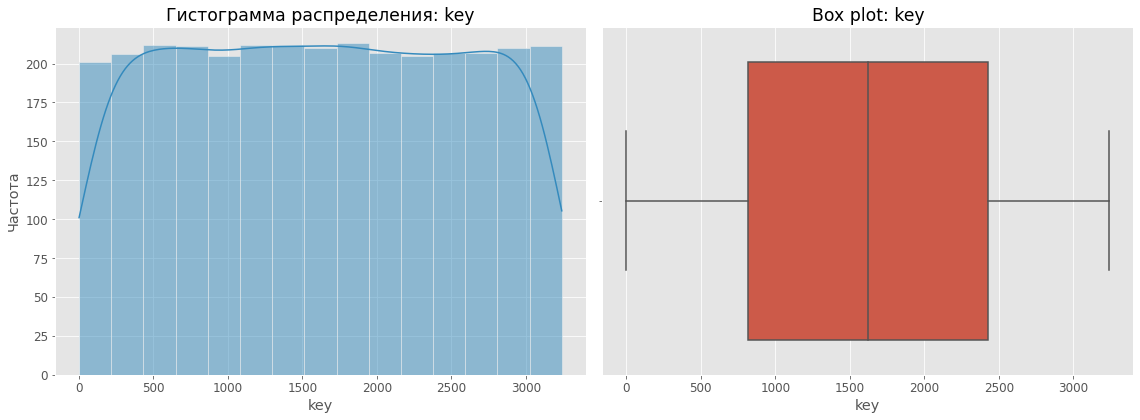

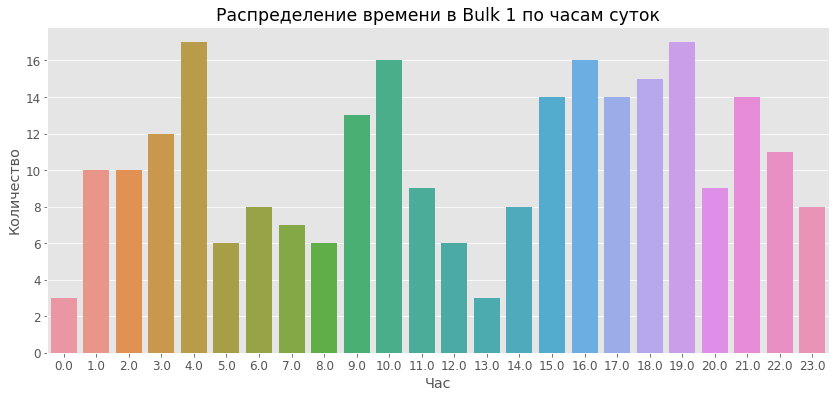

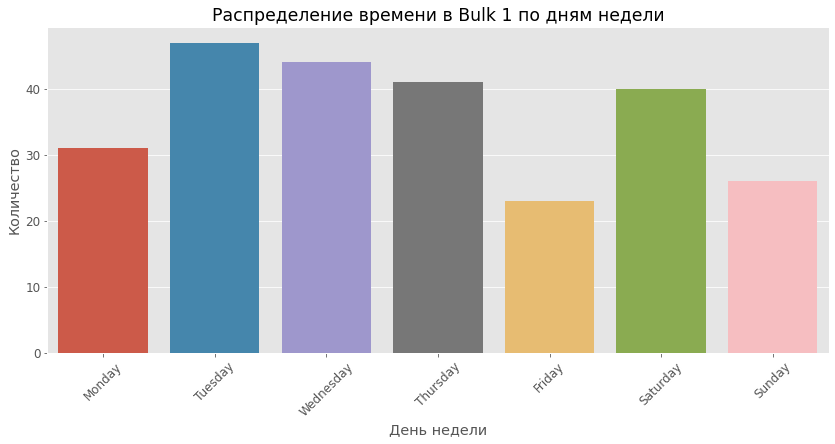

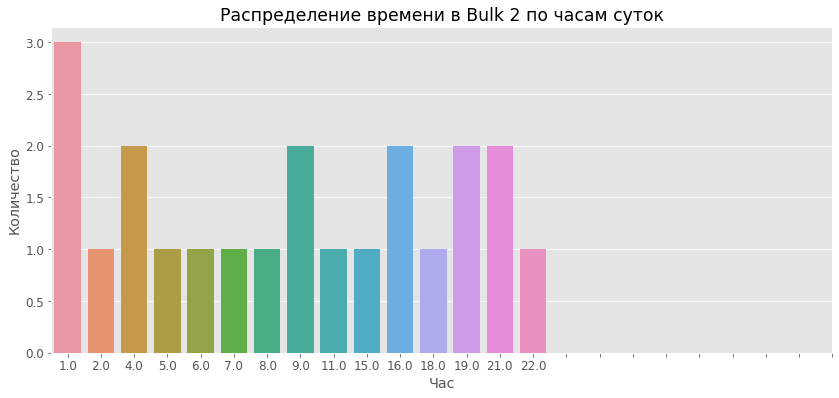

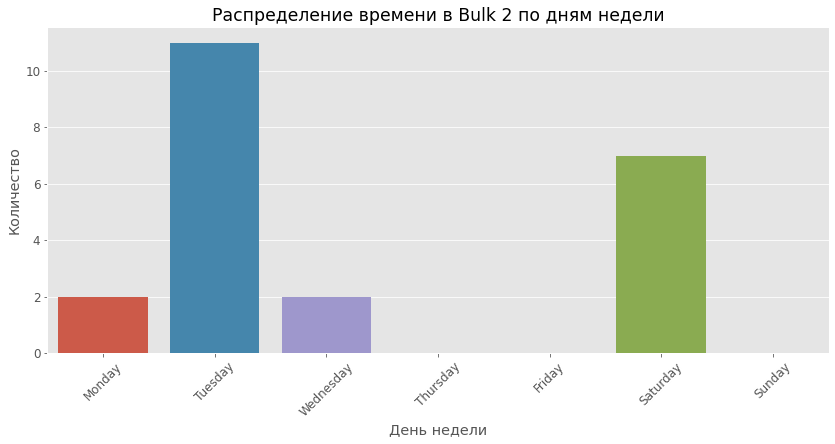

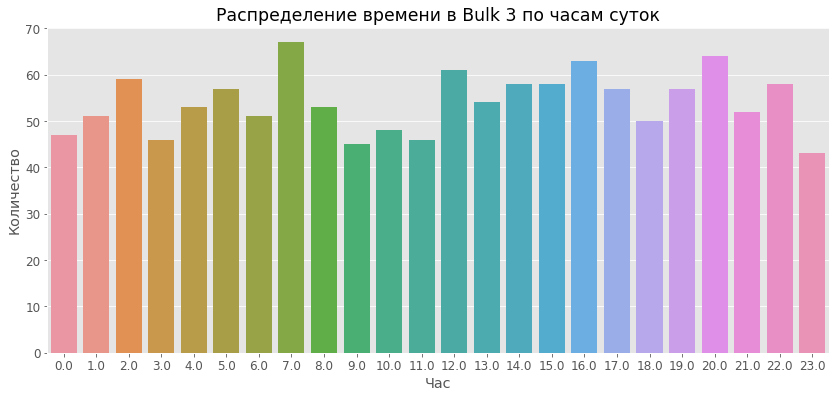

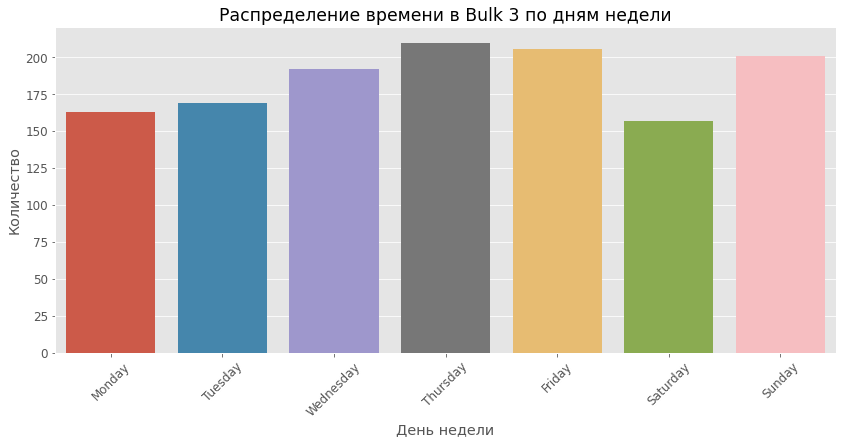

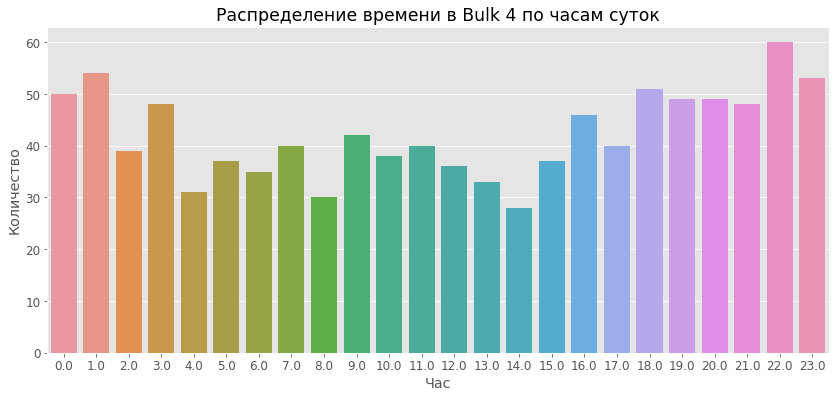

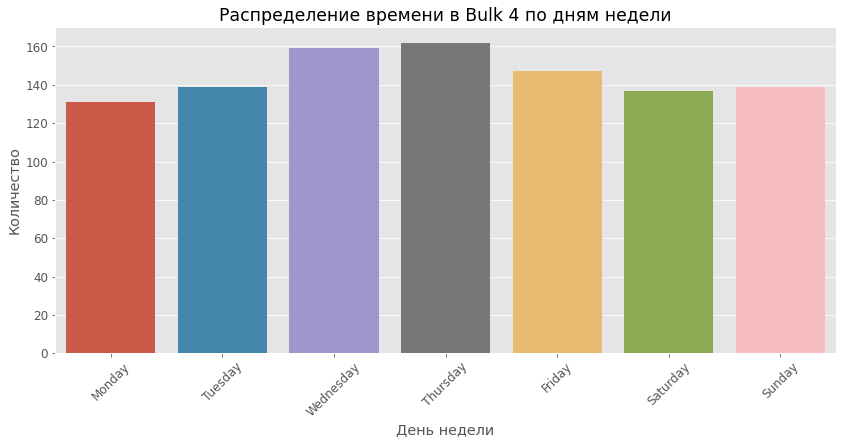

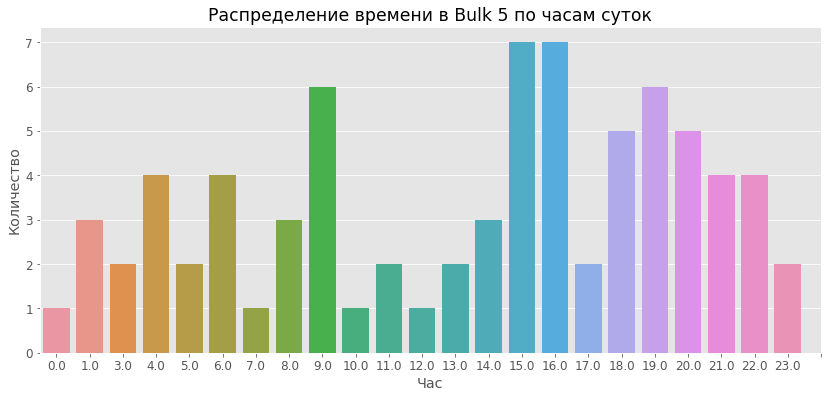

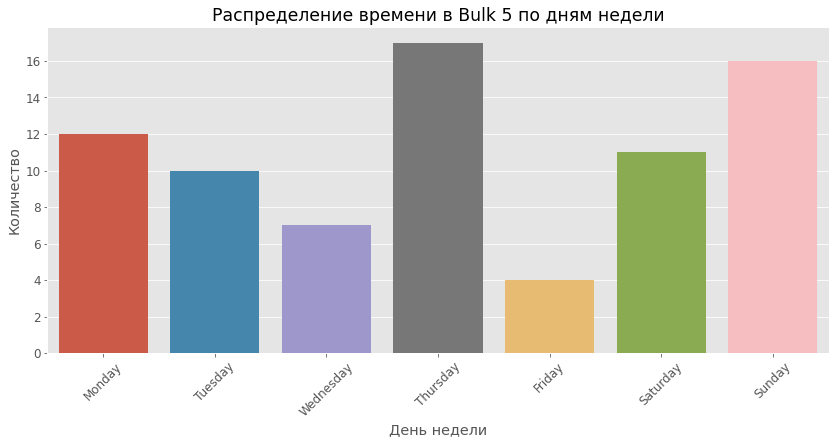

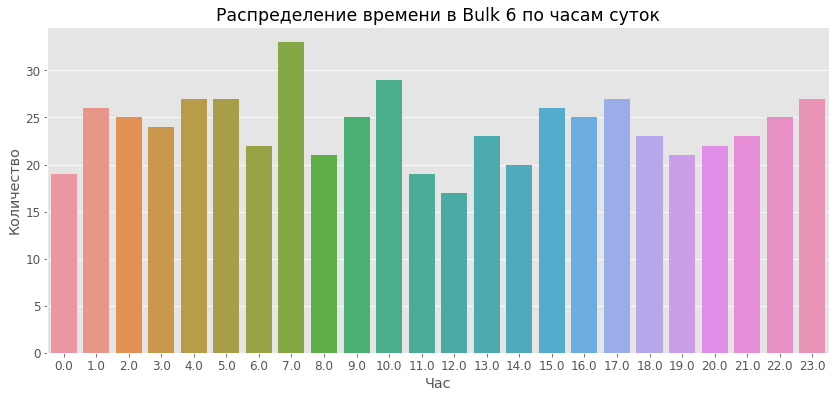

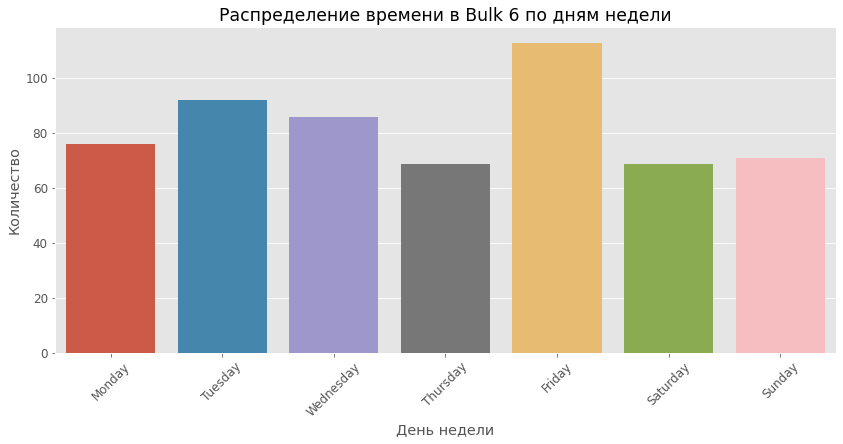

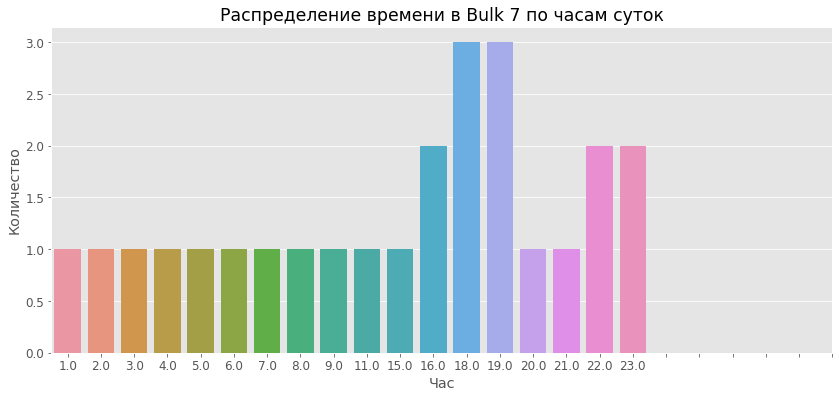

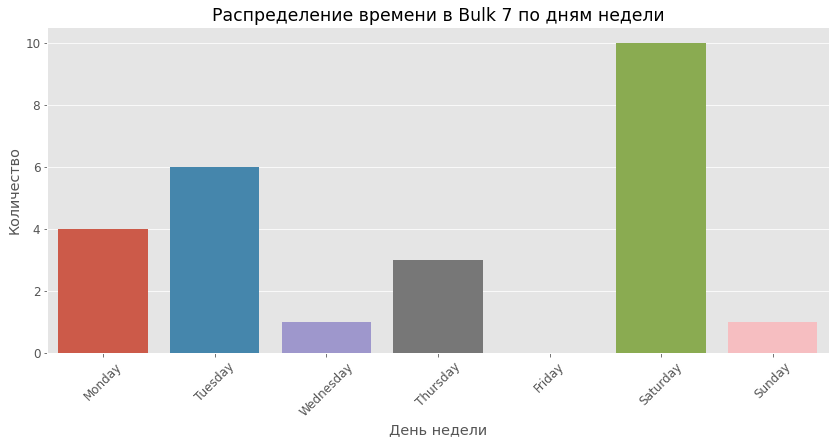

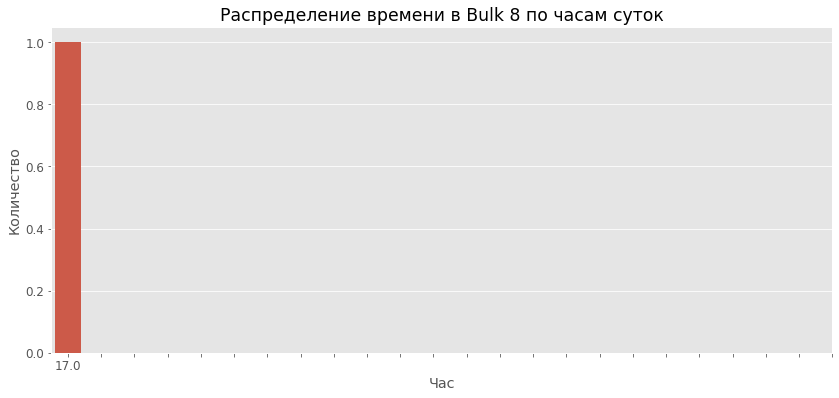

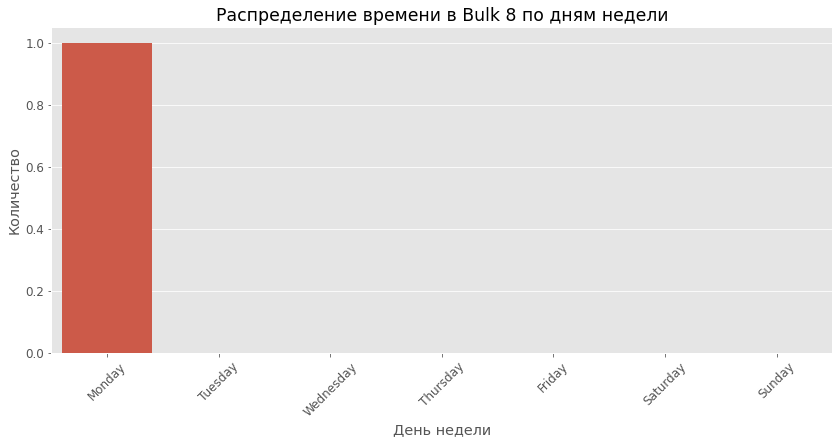

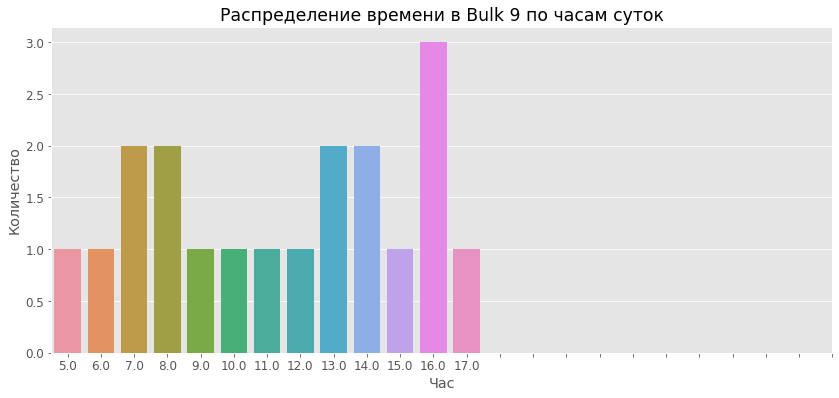

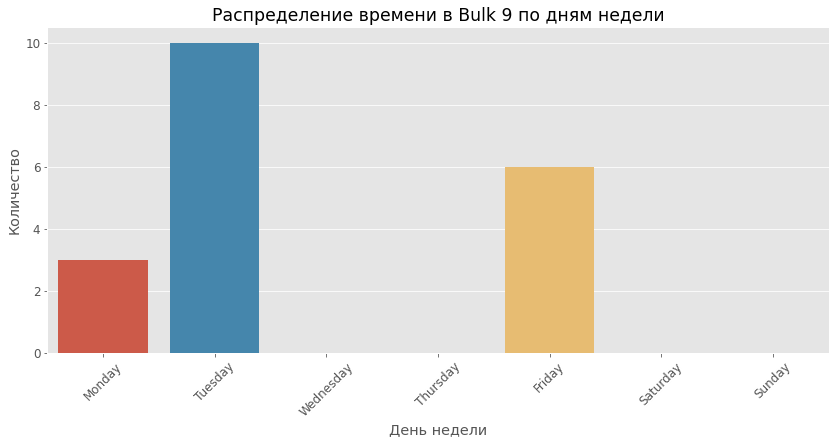

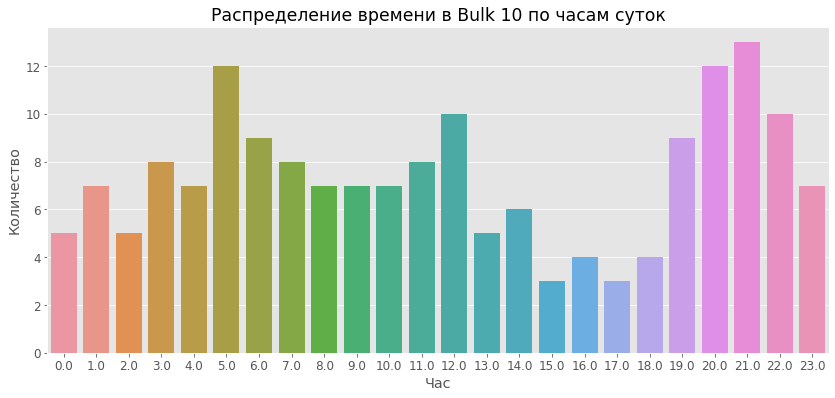

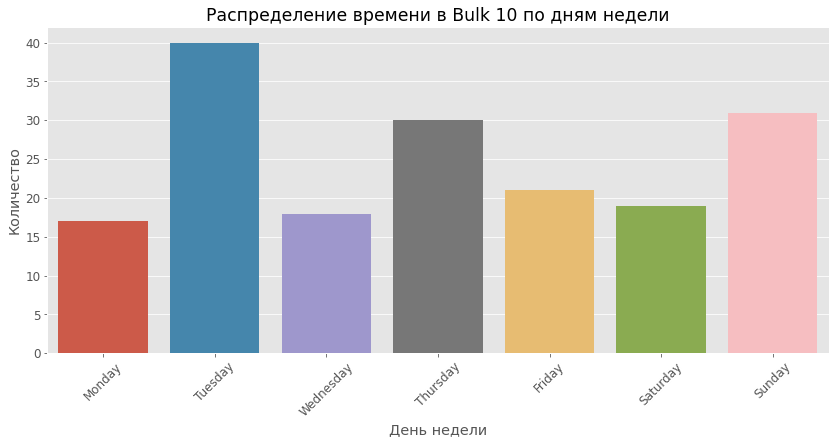

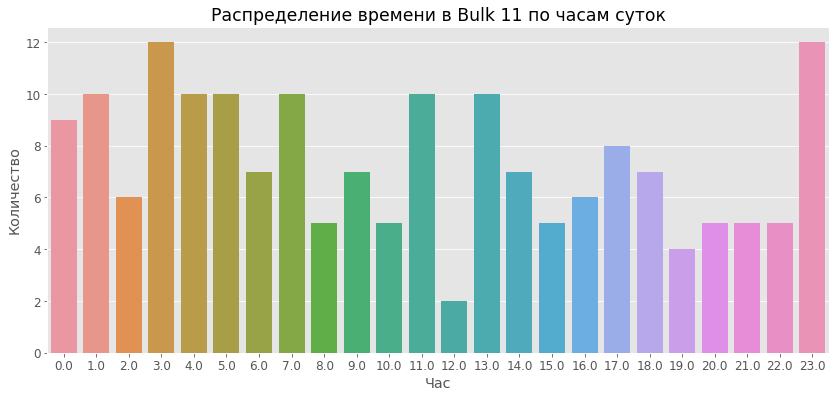

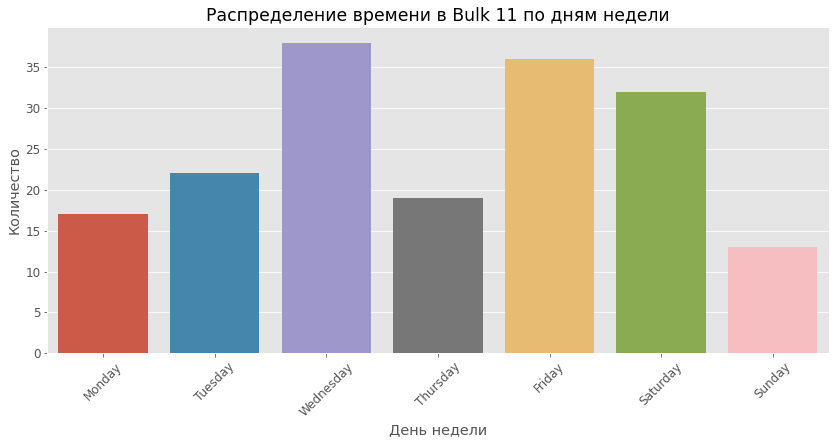

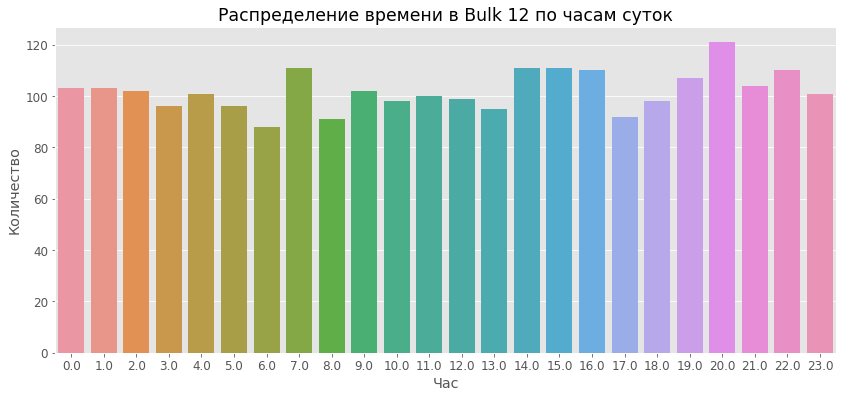

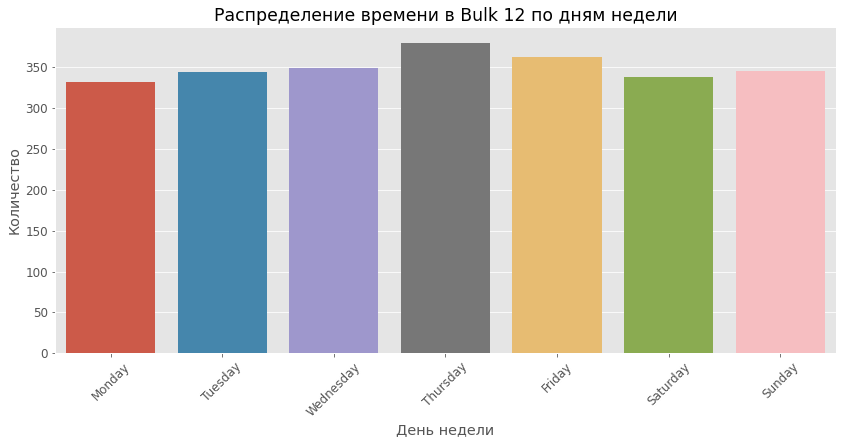

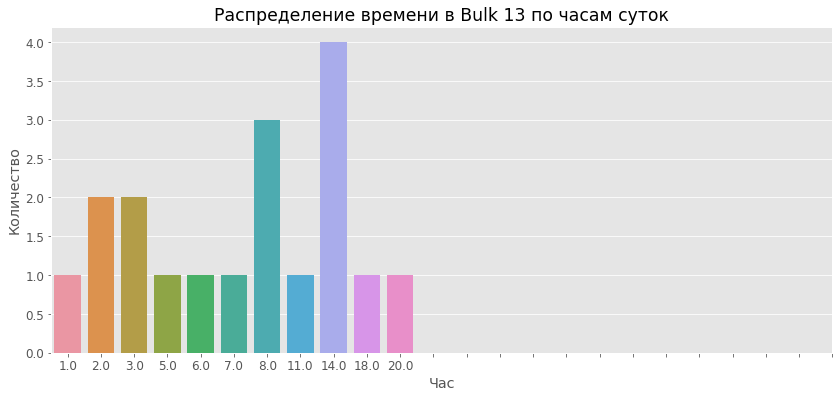

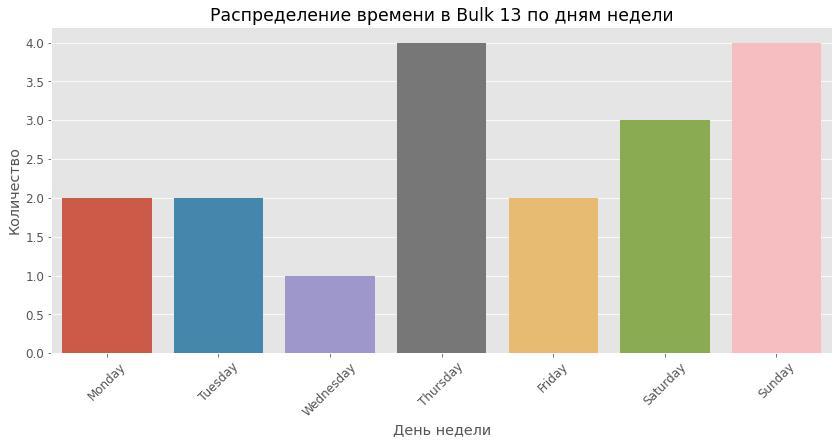

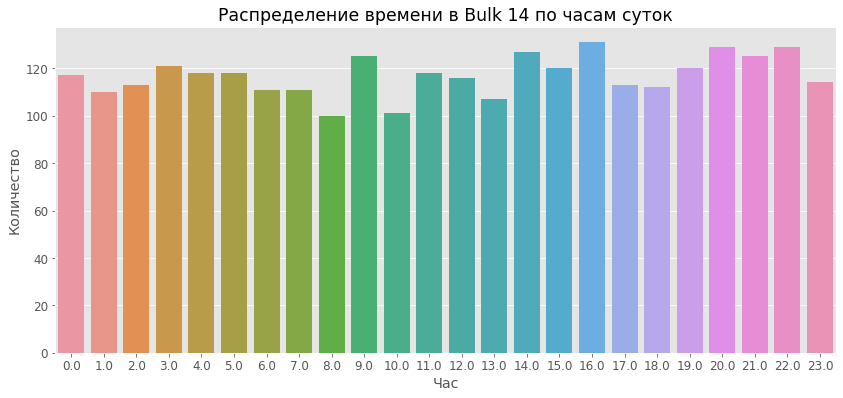

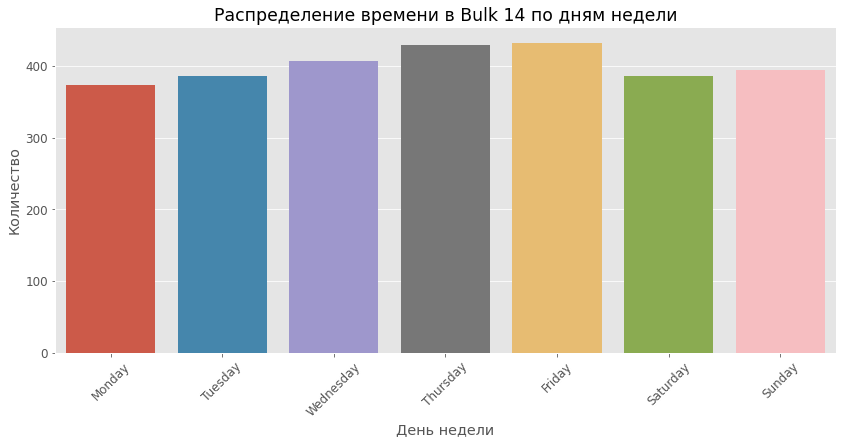

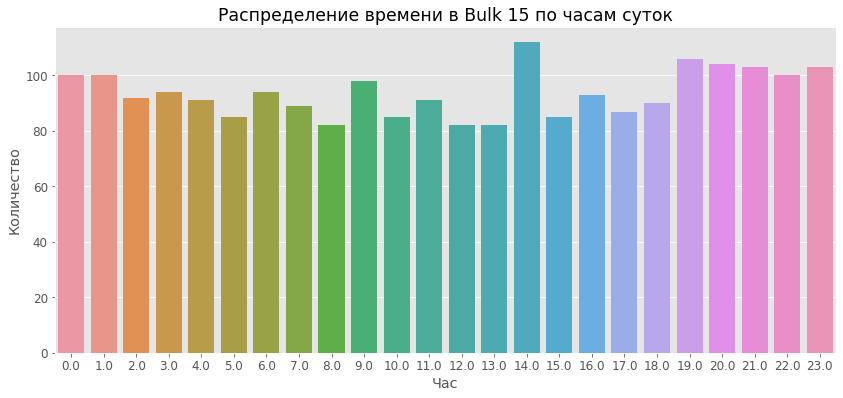

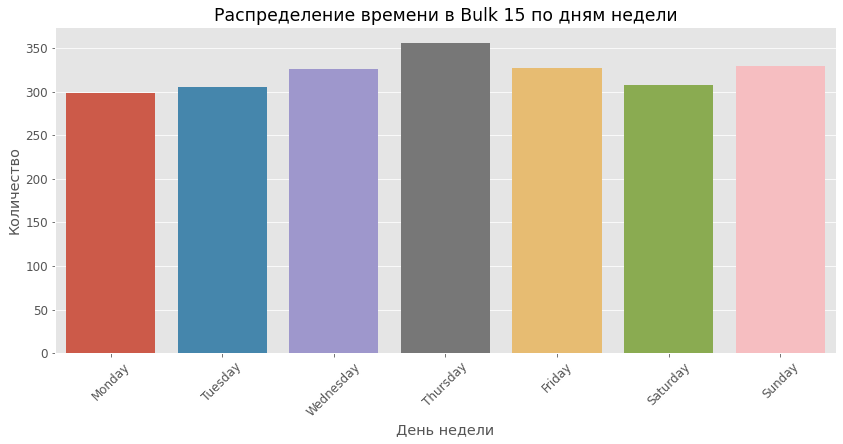

In [27]:
# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных (float64, int64)
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Если есть числовые столбцы
    if len(numeric_columns) > 0:
        fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
        
        # Если только один столбец, преобразуем axes в список
        if len(numeric_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(numeric_columns):
            # Гистограмма
            sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
            axes[i][0].set_title(f'Гистограмма распределения: {column}')
            axes[i][0].set_xlabel(column)
            axes[i][0].set_ylabel('Частота')
            
            # Box plot
            sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
            axes[i][1].set_title(f'Box plot: {column}')
            axes[i][1].set_xlabel(column)
        
        plt.tight_layout()
        plt.show()

# Функция для визуализации временных данных (object, предполагаются даты)
def visualize_datetime_columns(df):
    # Получаем столбцы типа object (предполагаем, что это временные метки)
    datetime_columns = df.select_dtypes(include=['object']).columns
    
    if datetime_columns.size > 0:
        df_temp = df.copy()
        
        # Преобразуем столбцы в datetime
        for col in datetime_columns:
            try:
                df_temp[col] = pd.to_datetime(df[col])
            except Exception as e:
                display(f"Невозможно преобразовать столбец {col} в формат datetime: {e}")
                continue
            
            # Визуализация распределения по часам
            plt.figure(figsize=(14, 6))
            df_temp['Час'] = df_temp[col].dt.hour
            sns.countplot(x='Час', data=df_temp[df_temp[col].notnull()])
            plt.title(f'Распределение времени в {col} по часам суток')
            plt.xlabel('Час')
            plt.ylabel('Количество')
            plt.xticks(range(0, 24))
            plt.show()
            
            # Визуализация распределения по дням недели
            plt.figure(figsize=(14, 6))
            df_temp['День недели'] = df_temp[col].dt.day_name()
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            sns.countplot(x='День недели', data=df_temp[df_temp[col].notnull()], order=day_order)
            plt.title(f'Распределение времени в {col} по дням недели')
            plt.xlabel('День недели')
            plt.ylabel('Количество')
            plt.xticks(rotation=45)
            plt.show()

# Вызываем функции для визуализации
visualize_numeric_columns(data_bulk_time)
visualize_datetime_columns(data_bulk_time)

### Шаг 2.3.3 Переименование столбцов в snake_case формат в data_bulk_time

In [28]:
# Переименование столбцов в snake_case формат
new_columns = {
    'key': 'key',
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2', 
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'
}


### Шаг 2.3.4 Стандартизация и анализ пропусков в data_bulk_time: конвертация названий в snake_case и фильтрация столбцов с пропусками >50%


In [29]:
data_bulk_time = data_bulk_time.rename(columns=new_columns)

# Проверка пропусков с новыми названиями
null_counts = data_bulk_time.isnull().sum()
null_percentages = null_counts / len(data_bulk_time) * 100

# Удаление столбцов с пропусками более 50%
columns_to_drop = null_percentages[null_percentages > 50].index
data_bulk_time = data_bulk_time.drop(columns=columns_to_drop)

# Перепроверка оставшихся пропусков
null_counts_after = data_bulk_time.isnull().sum()
null_percentages_after = null_counts_after / len(data_bulk_time) * 100

display("Анализ пропусков после очистки:")
display(pd.concat([null_counts_after, null_percentages_after], axis=1, 
                 keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков после очистки:'

,Количество пропусков,Процент пропусков
key,0,0.000000
bulk_12,679,21.700224
bulk_14,323,10.322787
bulk_15,881,28.155960


### Шаг 2.3.5 Преобразование столбцов data_bulk_time в datetime


In [30]:
# Преобразуем столбцы 'bulk_12', 'bulk_14', 'bulk_15' из object в datetime
data_bulk_time[['bulk_12', 'bulk_14', 'bulk_15']] = \
    data_bulk_time[['bulk_12', 'bulk_14', 'bulk_15']].apply(pd.to_datetime, errors='coerce')

# Проверка информации о типах данных
display("Информация о датафрейме после преобразования:")
data_bulk_time.info()

# Проверка первых строк
display("Первые строки данных после преобразования:")
display(data_bulk_time.head())
# Перепроверка оставшихся пропусков
null_counts_after = data_bulk_time.isnull().sum()
null_percentages_after = null_counts_after / len(data_bulk_time) * 100

display("Анализ пропусков после очистки:")
display(pd.concat([null_counts_after, null_percentages_after], axis=1, 
                 keys=['Количество пропусков', 'Процент пропусков']))

'Информация о датафрейме после преобразования:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_12  2450 non-null   datetime64[ns]
 2   bulk_14  2806 non-null   datetime64[ns]
 3   bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1)
memory usage: 97.9 KB


'Первые строки данных после преобразования:'

,key,bulk_12,bulk_14,bulk_15
0,1,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47


'Анализ пропусков после очистки:'

,Количество пропусков,Процент пропусков
key,0,0.000000
bulk_12,679,21.700224
bulk_14,323,10.322787
bulk_15,881,28.155960


### Шаг 2.3.6 Обработка пропусков в data_bulk_time 

In [31]:

# Преобразуем столбцы 'bulk_12', 'bulk_14', 'bulk_15' в формат datetime (если еще не преобразованы)
data_bulk_time[['bulk_12', 'bulk_14', 'bulk_15']] = \
    data_bulk_time[['bulk_12', 'bulk_14', 'bulk_15']].apply(pd.to_datetime, errors='coerce')

# Создаем копию данных для обработки
data_bulk_time_processed = data_bulk_time.copy()

# Заполняем пропуски предыдущим значением (forward fill)
data_bulk_time_processed[['bulk_12', 'bulk_14', 'bulk_15']] = \
    data_bulk_time_processed[['bulk_12', 'bulk_14', 'bulk_15']].fillna(method='ffill')

# Если остались пропуски (например, в начале столбца), заполняем следующим значением (backward fill)
data_bulk_time_processed[['bulk_12', 'bulk_14', 'bulk_15']] = \
    data_bulk_time_processed[['bulk_12', 'bulk_14', 'bulk_15']].fillna(method='bfill')

# Обновляем исходный датафрейм
data_bulk_time = data_bulk_time_processed.copy()

# Проверка результатов
# Анализ пропусков после заполнения
null_counts = data_bulk_time.isnull().sum()
null_percentages = null_counts / len(data_bulk_time) * 100

display("Анализ пропусков после заполнения методом forward fill:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['Количество пропусков', 'Процент пропусков']))

# Проверка первых строк после заполнения
display("Первые строки данных после заполнения методом forward fill:")
display(data_bulk_time.head())

'Анализ пропусков после заполнения методом forward fill:'

,Количество пропусков,Процент пропусков
key,0,0.0
bulk_12,0,0.0
bulk_14,0,0.0
bulk_15,0,0.0


'Первые строки данных после заполнения методом forward fill:'

,key,bulk_12,bulk_14,bulk_15
0,1,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47


## Шаг 2.4 Инициализируем переменную data_wire_time 

In [32]:
# Допустим, одна из таблиц называется "data_wire_time"
data_wire_time = pd.read_sql("SELECT * FROM data_wire_time", engine)
data_wire_time.info()
data_wire_time.describe().transpose()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


### Шаг 2.4.1 Проверка data_wire_time на пропуски в данных

In [33]:
# Проверка на пропуски в данных
null_counts = data_wire_time.isnull().sum()
null_percentages = null_counts / len(data_wire_time) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
Wire 1,26,0.843882
Wire 2,2002,64.978903
Wire 3,3018,97.955209
Wire 4,3067,99.545602
Wire 5,3080,99.967543
Wire 6,3008,97.630639
Wire 7,3070,99.642973
Wire 8,3062,99.383317
Wire 9,3052,99.058747


### Шаг 2.4.2 Визуализация и анализ данных в data_bulk_time

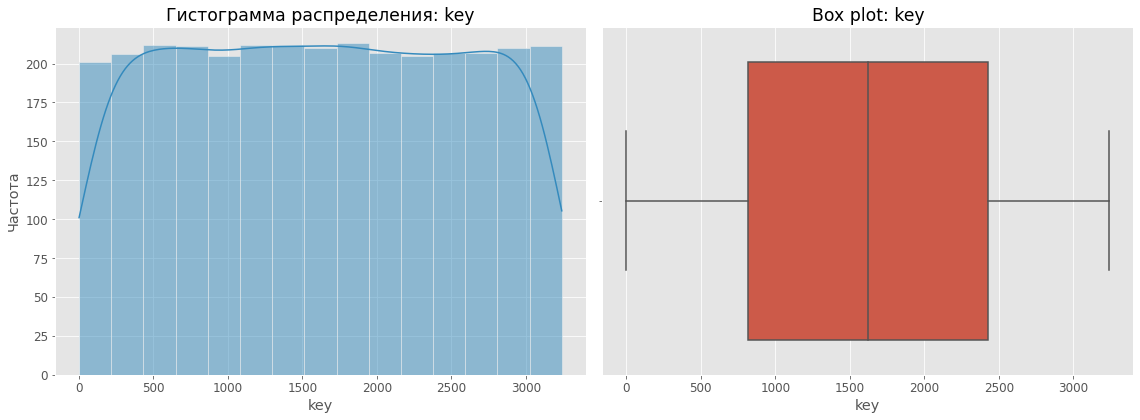

In [34]:

# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных (float64, int64)
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_columns) > 0:
        fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
        
        # Если только один столбец, преобразуем axes в список
        if len(numeric_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(numeric_columns):
            # Гистограмма
            sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
            axes[i][0].set_title(f'Гистограмма распределения: {column}')
            axes[i][0].set_xlabel(column)
            axes[i][0].set_ylabel('Частота')
            
            # Box plot
            sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
            axes[i][1].set_title(f'Box plot: {column}')
            axes[i][1].set_xlabel(column)
        
        plt.tight_layout()
        plt.show()

# Функция для визуализации временных данных (object, предполагаются даты)
def visualize_datetime_columns(df):
    datetime_columns = df.select_dtypes(include=['object']).columns
    
    if datetime_columns.size > 0:
        df_temp = df.copy()
        
        for col in datetime_columns:
            try:
                df_temp[col] = pd.to_datetime(df[col])
            except Exception as e:
                display(f"Невозможно преобразовать столбец {col} в формат datetime: {e}")
                continue
            
            # Визуализация распределения по часам
            plt.figure(figsize=(14, 6))
            df_temp['Час'] = df_temp[col].dt.hour
            sns.countplot(x='Час', data=df_temp[df_temp[col].notnull()])
            plt.title(f'Распределение времени в {col} по часам суток')
            plt.xlabel('Час')
            plt.ylabel('Количество')
            plt.xticks(range(0, 24))
            plt.show()
            
            # Визуализация распределения по дням недели
            plt.figure(figsize=(14, 6))
            df_temp['День недели'] = df_temp[col].dt.day_name()
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            sns.countplot(x='День недели', data=df_temp[df_temp[col].notnull()], order=day_order)
            plt.title(f'Распределение времени в {col} по дням недели')
            plt.xlabel('День недели')
            plt.ylabel('Количество')
            plt.xticks(rotation=45)
            plt.show()

            # Визуализация распределения по месяцам
            plt.figure(figsize=(14, 6))
            df_temp['Месяц'] = df_temp[col].dt.month_name()
            month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                           'July', 'August', 'September', 'October', 'November', 'December']
            sns.countplot(x='Месяц', data=df_temp[df_temp[col].notnull()], order=month_order)
            plt.title(f'Распределение времени в {col} по месяцам')
            plt.xlabel('Месяц')
            plt.ylabel('Количество')
            plt.xticks(rotation=45)
            plt.show()

# Вызываем функции для визуализации
visualize_numeric_columns(data_bulk_time)
visualize_datetime_columns(data_bulk_time)

### Шаг 2.4.3 Переименование столбцов в snake_case формат в data_wire_time

In [35]:
# Создаем словарь для переименования столбцов
new_columns = {
    'key': 'key',
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9'
}

# Применяем переименование
data_wire_time = data_wire_time.rename(columns=new_columns)

# Проверяем пропуски с новыми названиями
null_counts = data_wire_time.isnull().sum()
null_percentages = null_counts / len(data_wire_time) * 100

# Отображаем результаты
display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))
data_wire_time.info()
data_wire_time.head()

'Анализ пропусков в данных:'

,количество_пропусков,процент_пропусков
key,0,0.000000
wire_1,26,0.843882
wire_2,2002,64.978903
wire_3,3018,97.955209
wire_4,3067,99.545602
wire_5,3080,99.967543
wire_6,3008,97.630639
wire_7,3070,99.642973
wire_8,3062,99.383317
wire_9,3052,99.058747


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


### Шаг 2.4.4 Обработка пропусков в data_wire_time 

In [36]:

# Преобразуем столбцы 'wire_1', 'wire_2', ..., 'wire_9' в формат datetime
date_columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_time[date_columns] = \
    data_wire_time[date_columns].apply(lambda x: pd.to_datetime(x, errors='coerce'))

# Создаем копию данных для обработки
data_wire_time_processed = data_wire_time.copy()

# Заполняем пропуски предыдущим значением (forward fill)
data_wire_time_processed[date_columns] = \
    data_wire_time_processed[date_columns].fillna(method='ffill')

# Если остались пропуски (например, в начале столбца), заполняем следующим значением (backward fill)
data_wire_time_processed[date_columns] = \
    data_wire_time_processed[date_columns].fillna(method='bfill')

# Обновляем исходный датафрейм
data_wire_time = data_wire_time_processed.copy()

# Проверка результатов
# Анализ пропусков после заполнения
null_counts = data_wire_time.isnull().sum()
null_percentages = null_counts / len(data_wire_time) * 100

display("Анализ пропусков после заполнения методом forward fill:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['Количество пропусков', 'Процент пропусков']))

# Проверка первых строк после заполнения
display("Первые строки данных после заполнения методом forward fill:")
display(data_wire_time.head())

'Анализ пропусков после заполнения методом forward fill:'

,Количество пропусков,Процент пропусков
key,0,0.0
wire_1,0,0.0
wire_2,0,0.0
wire_3,0,0.0
wire_4,0,0.0
wire_5,0,0.0
wire_6,0,0.0
wire_7,0,0.0
wire_8,0,0.0
wire_9,0,0.0


'Первые строки данных после заполнения методом forward fill:'

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
1,2,2019-05-03 11:36:50,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
2,3,2019-05-03 12:11:46,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
3,4,2019-05-03 12:43:22,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27


## Шаг 2.5 Инициализируем переменную data_gas

In [37]:
# Допустим, одна из таблиц называется "data_gas"
data_gas = pd.read_sql("SELECT * FROM data_gas", engine)
data_gas.info()
data_gas.describe().transpose()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Шаг 2.5.1 Проверка data_gas на пропуски в данных

In [38]:
# Проверка на пропуски в данных
null_counts = data_gas.isnull().sum()
null_percentages = null_counts / len(data_gas) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.0
Газ 1,0,0.0


### Шаг 2.5.2 Визуализация и анализ данных в data_gas

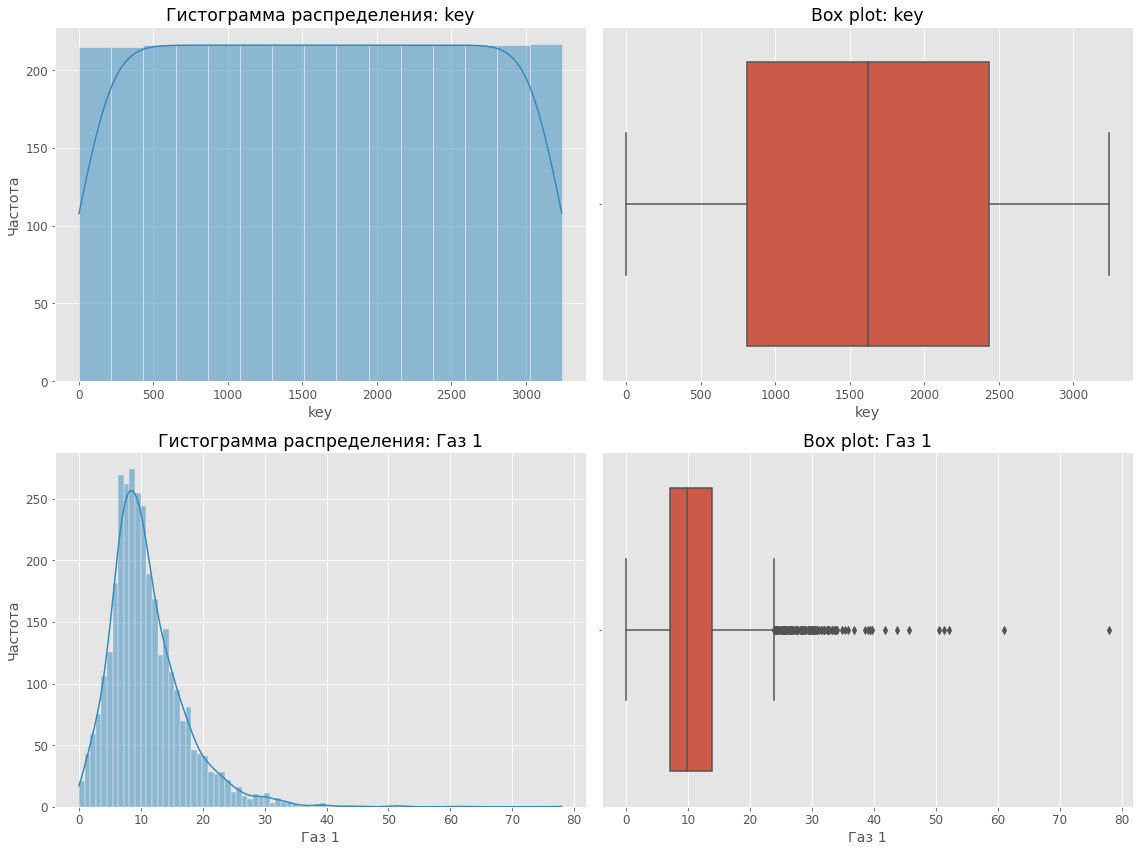

'Категориальные столбцы (object) отсутствуют.'

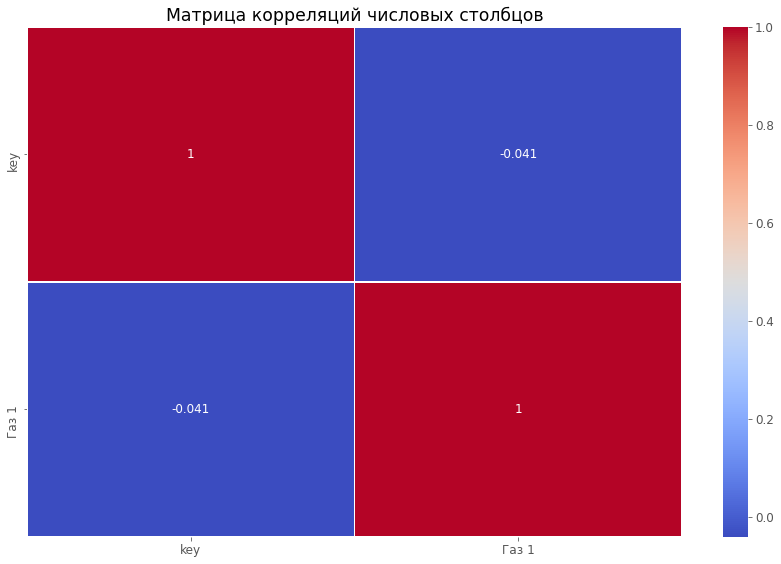

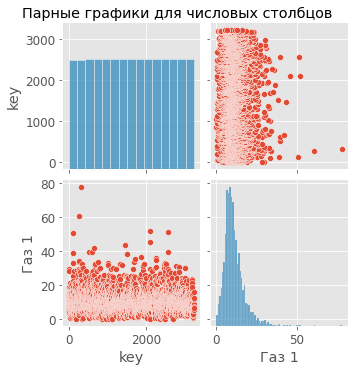

In [39]:
# Предполагаем, что data_gas уже загружен
# data_gas = pd.read_sql("SELECT * FROM data_gas", engine)

# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных (float64, int64)
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_columns) > 0:
        fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
        
        # Если только один столбец, преобразуем axes в список
        if len(numeric_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(numeric_columns):
            # Гистограмма
            sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
            axes[i][0].set_title(f'Гистограмма распределения: {column}')
            axes[i][0].set_xlabel(column)
            axes[i][0].set_ylabel('Частота')
            
            # Box plot
            sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
            axes[i][1].set_title(f'Box plot: {column}')
            axes[i][1].set_xlabel(column)
        
        plt.tight_layout()
        plt.show()

# Функция для визуализации категориальных данных (object)
def visualize_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    if categorical_columns.size > 0:
        fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(14, 6*len(categorical_columns)))
        
        # Если только один категориальный столбец, axes не будет массивом
        if len(categorical_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(categorical_columns):
            value_counts = df[column].value_counts().sort_values(ascending=False)
            
            # Если уникальных значений слишком много, ограничиваем для наглядности
            if len(value_counts) > 20:
                value_counts = value_counts.head(20)
                axes[i].set_title(f'Топ 20 значений: {column}')
            else:
                axes[i].set_title(f'Распределение значений: {column}')
            
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Количество')
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        display("Категориальные столбцы (object) отсутствуют.")

# Функция для анализа корреляций между числовыми столбцами
def visualize_correlations(df):
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    if len(numeric_df.columns) > 1:
        # Создаем тепловую карту корреляций
        plt.figure(figsize=(12, 8))
        correlation_matrix = numeric_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Матрица корреляций числовых столбцов')
        plt.tight_layout()
        plt.show()
        
        # Создаем pairplot для визуализации взаимосвязей
        sns.pairplot(numeric_df)
        plt.suptitle('Парные графики для числовых столбцов', y=1.02)
        plt.show()
    else:
        display("Недостаточно числовых столбцов для анализа корреляций.")

# Вызываем функции для визуализации
visualize_numeric_columns(data_gas)
visualize_categorical_columns(data_gas)
visualize_correlations(data_gas)

### Шаг 2.5.3 Переименуем столбец "Газ 1" на более понятное название, например "gas_value"

'Столбцы после переименования:'

Index(['key', 'gas_value'], dtype='object')

'Информация о датафрейме после переименования:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3239 non-null   int64  
 1   gas_value  3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

'Статистика по данным:'

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
gas_value,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.00%
gas_value,0,0.00%


'Количество дубликатов в данных:'

0

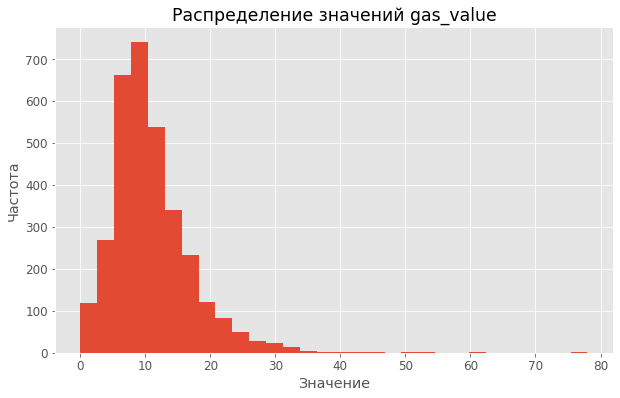

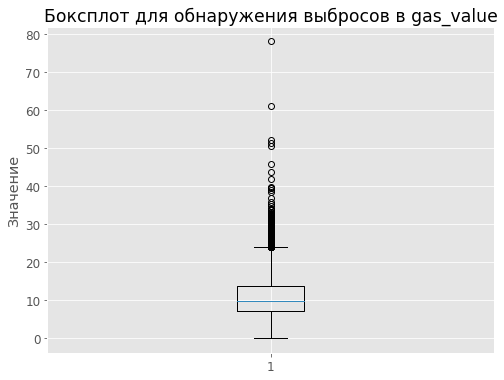

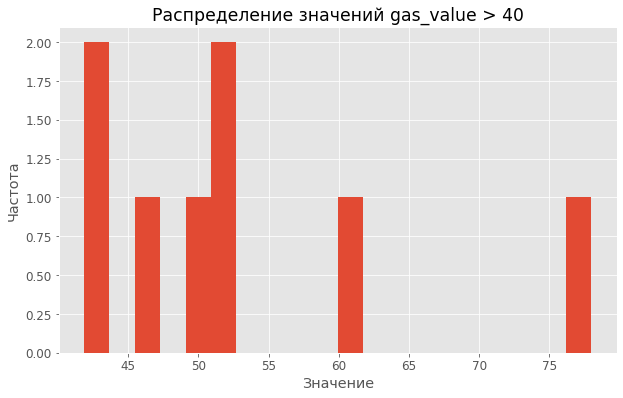

In [40]:

# Переименуем столбец "Газ 1" на более понятное название, например "gas_value"
data_gas = data_gas.rename(columns={"Газ 1": "gas_value"})

# Проверим, что переименование выполнено успешно
display("Столбцы после переименования:")
display(data_gas.columns)

# Проверка данных
display("Информация о датафрейме после переименования:")
display(data_gas.info())

# Статистика по данным
display("Статистика по данным:")
display(data_gas.describe().transpose())

# Проверка на пропуски
null_counts = data_gas.isnull().sum()
null_percentages = null_counts / len(data_gas) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков'])
        .style.format({
            'Количество пропусков': '{:.0f}',
            'Процент пропусков': '{:.2f}%'
        }))

# Проверка на дубликаты
display("Количество дубликатов в данных:")
display(data_gas.duplicated().sum())



plt.figure(figsize=(10, 6))
plt.hist(data_gas['gas_value'], bins=30)
plt.title('Распределение значений gas_value')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

# Проверка на выбросы с помощью boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data_gas['gas_value'])
plt.title('Боксплот для обнаружения выбросов в gas_value')
plt.ylabel('Значение')
plt.show()

# График значений выше 40
plt.figure(figsize=(10, 6))
plt.hist(data_gas[data_gas['gas_value'] > 40]['gas_value'], bins=20)
plt.title('Распределение значений gas_value > 40')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()


## Шаг 2.6 Инициализируем переменную data_temp

In [41]:
# Допустим, одна из таблиц называется "data_temp"
data_temp = pd.read_sql("SELECT * FROM data_temp", engine , parse_dates=[1])
# Загрузка данных из CSV файла с парсингом даты



data_temp.info()
data_temp.describe().transpose()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


### Шаг 2.6.1 Переименование столбцов в data_temp в snake case

In [42]:
# Переименование столбцов в data_temp
data_temp = data_temp.rename(columns={
    'key': 'key',
    'Время замера': 'measurement_time',
    'Температура': 'temperature'
})
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   key               18092 non-null  int64 
 1   measurement_time  18092 non-null  object
 2   temperature       14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


### Шаг 2.6.2 Проверка на пропуски в data_temp

In [43]:
# Проверка на пропуски в данных
null_counts = data_temp.isnull().sum()
null_percentages = null_counts / len(data_temp) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
measurement_time,0,0.000000
temperature,3427,18.942074


### Шаг 2.6.3  Исследование распределения температур в диапазоне до 1550°C и 1500°C в data_temp

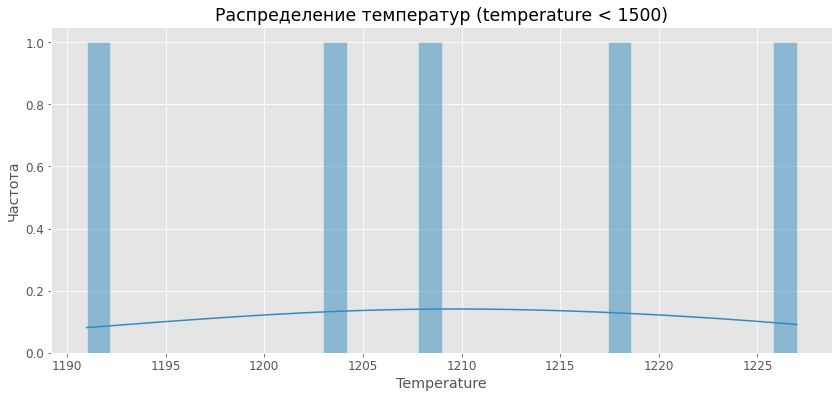

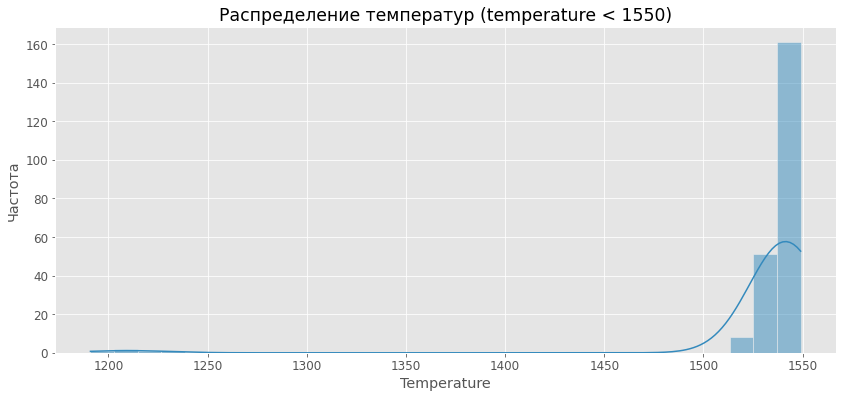

In [44]:
# Преобразуем столбец в числовой формат
data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')

# График для temperature < 1500
plt.figure(figsize=(14, 6))
sns.histplot(data_temp[data_temp['temperature'] < 1500]['temperature'], bins=30, kde=True)
plt.title('Распределение температур (temperature < 1500)')
plt.xlabel('Temperature')
plt.ylabel('Частота')
plt.show()

# График для temperature < 1550
plt.figure(figsize=(14, 6))
sns.histplot(data_temp[data_temp['temperature'] < 1550]['temperature'], bins=30, kde=True)
plt.title('Распределение температур (temperature < 1550)')
plt.xlabel('Temperature')
plt.ylabel('Частота')
plt.show()


### Шаг 2.6.4 Форматирование данных: конвертация температурных показателей в числовой формат и времени измерений в datetime

In [45]:
# Преобразуем 'temperature' в числовой формат
data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')

# Преобразуем 'measurement_time' в datetime
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'], errors='coerce')

### Шаг 2.6.5 Анализ пропусков температуры

"Количество строк с отсутствующими значениями в столбце 'temperature': 3427"

'Процент пропусков: 18.94%'

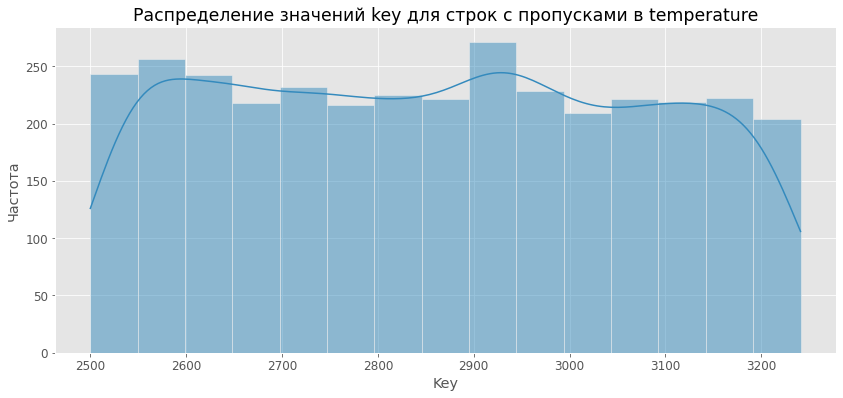

In [46]:

# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Преобразуем столбец 'temperature' в float64, если он еще не преобразован
try:
    data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')
except Exception as e:
    display(f"Невозможно преобразовать столбец 'temperature' в числовой формат: {e}")

# Подсчет количества строк, где temperature отсутствует
missing_temp_count = data_temp['temperature'].isna().sum()
display(f"Количество строк с отсутствующими значениями в столбце 'temperature': {missing_temp_count}")
display(f"Процент пропусков: {(missing_temp_count / len(data_temp) * 100):.2f}%")

# Фильтрация строк, где temperature отсутствует
missing_temp_data = data_temp[data_temp['temperature'].isna()]

# Визуализация значений столбца 'key' для строк с пропусками в 'temperature'
if not missing_temp_data.empty:
    plt.figure(figsize=(14, 6))
    sns.histplot(missing_temp_data['key'].dropna(), kde=True)
    plt.title('Распределение значений key для строк с пропусками в temperature')
    plt.xlabel('Key')
    plt.ylabel('Частота')
    plt.show()
else:
    display("Нет строк с пропусками в столбце 'temperature' для визуализации.")

### Шаг 2.6.6 Группировка температурных данных в data_temp

In [47]:
data_temp = data_temp.groupby(by='key').agg({'measurement_time': ['first', 'last'], 'temperature': ['first', 'last']}).reset_index()
data_temp.columns = ['key', 'measurement_time_first', 'measurement_time_last', 'temperature_first', 'temperature_last']
data_temp['measurement_time_diff'] = data_temp['measurement_time_last'] - data_temp['measurement_time_first']
data_temp['measurement_time_diff'] = data_temp['measurement_time_diff'].dt.seconds
data_temp = data_temp.query('key < 2500')
data_temp.head()
data_temp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2477 non-null   int64         
 1   measurement_time_first  2477 non-null   datetime64[ns]
 2   measurement_time_last   2477 non-null   datetime64[ns]
 3   temperature_first       2477 non-null   float64       
 4   temperature_last        2477 non-null   float64       
 5   measurement_time_diff   2477 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.5 KB


### Шаг 2.6.7 Визуализация для исследования распределения значений в числовых, категориальных и временных столбцах data_temp

"Невозможно преобразовать столбец 'temperature' в числовой формат: 'temperature'"

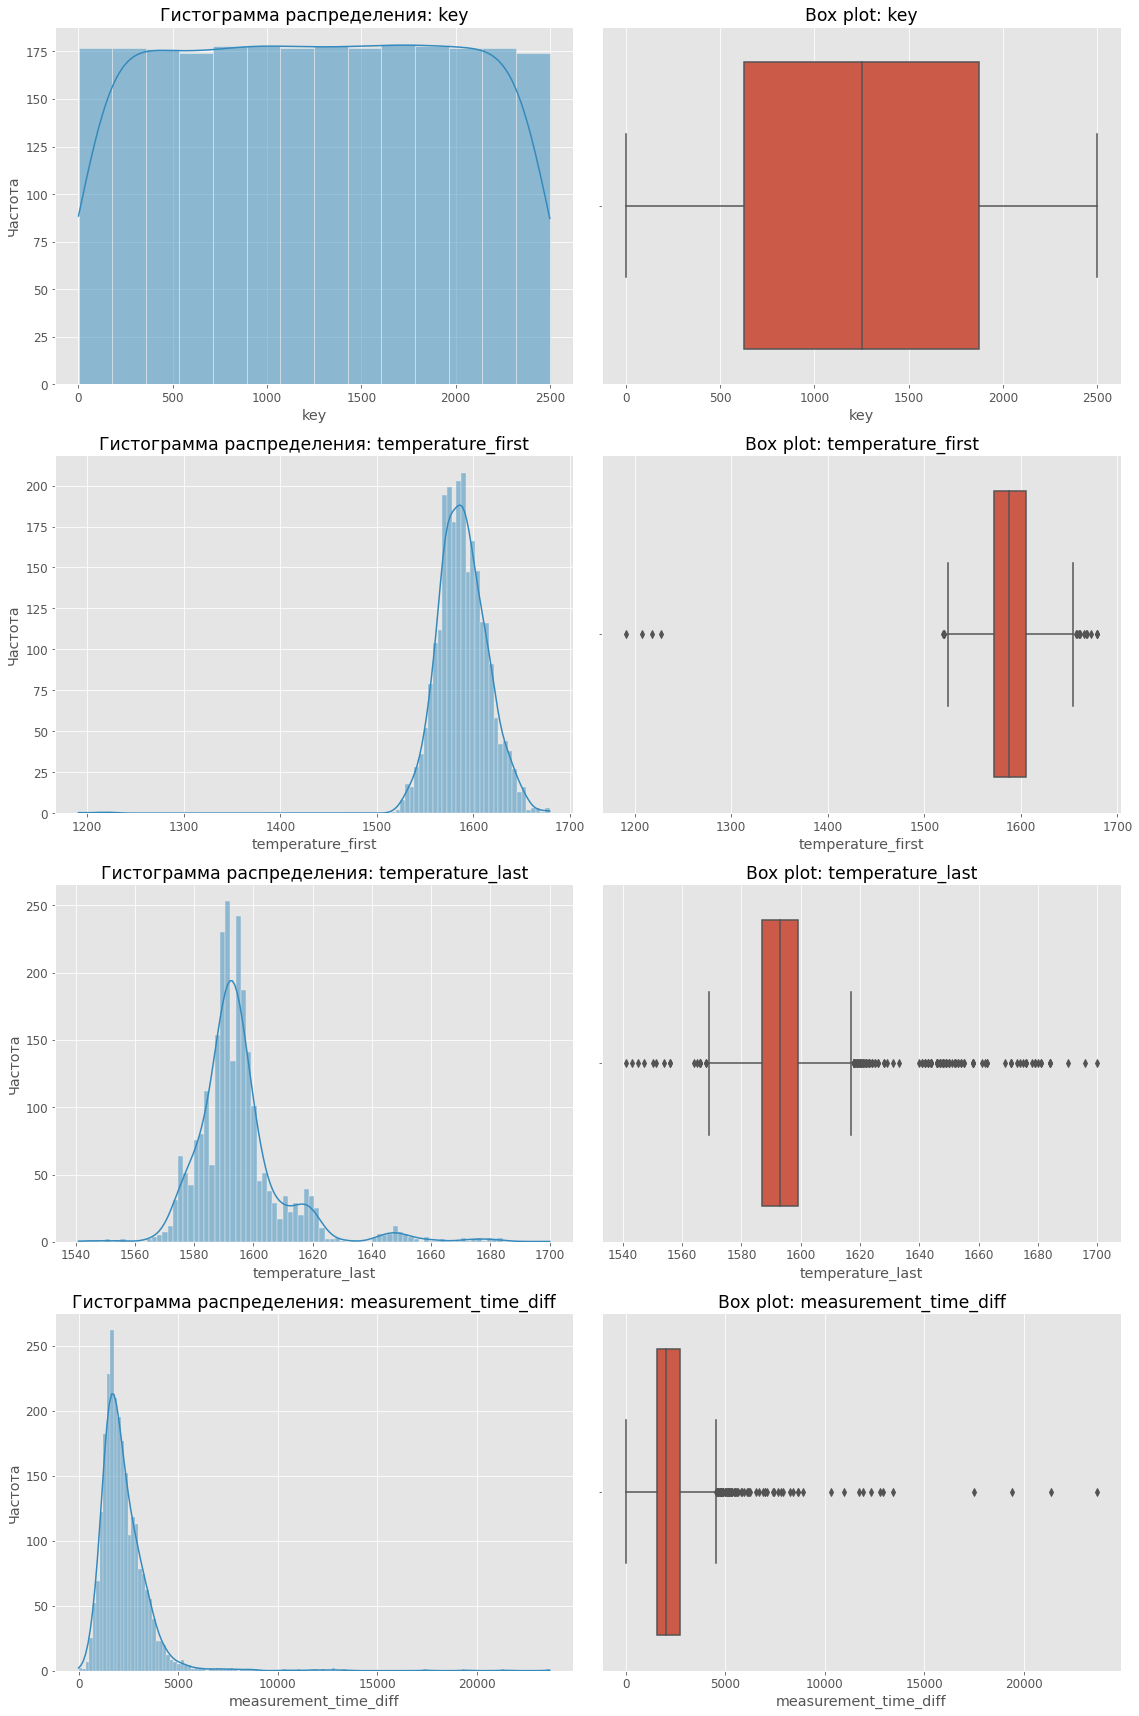

"Невозможно преобразовать столбец measurement_time в формат datetime: 'measurement_time'"

In [48]:
# Предполагаем, что data_temp уже загружен
# data_temp = pd.read_sql("SELECT * FROM data_temp", engine)

# Установка стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Преобразуем столбец 'temperature' в float64, если он содержит числовые данные
try:
    data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')
except Exception as e:
    display(f"Невозможно преобразовать столбец 'temperature' в числовой формат: {e}")

# Создаем функцию для визуализации числовых данных (float64, int64)
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
    
    if len(numeric_columns) == 1:
        axes = [axes]
    
    for i, column in enumerate(numeric_columns):
        sns.histplot(df[column].dropna(), kde=True, ax=axes[i][0])
        axes[i][0].set_title(f'Гистограмма распределения: {column}')
        axes[i][0].set_xlabel(column)
        axes[i][0].set_ylabel('Частота')
        
        sns.boxplot(x=df[column].dropna(), ax=axes[i][1])
        axes[i][1].set_title(f'Box plot: {column}')
        axes[i][1].set_xlabel(column)
        
    plt.tight_layout()
    plt.show()

# Создаем функцию для визуализации временных данных
def visualize_datetime_columns(df):
    date_column = 'measurement_time'
    
    df_temp = df.copy()
    try:
        df_temp[date_column] = pd.to_datetime(df[date_column])
    except Exception as e:
        display(f"Невозможно преобразовать столбец {date_column} в формат datetime: {e}")
        return
    
    plt.figure(figsize=(14, 6))
    df_temp['hour_of_measurement'] = df_temp[date_column].dt.hour
    sns.countplot(x='hour_of_measurement', data=df_temp)
    plt.title('Распределение замеров по часам суток')
    plt.xlabel('Час')
    plt.ylabel('Количество')
    plt.xticks(range(0, 24))
    plt.show()
    
    plt.figure(figsize=(14, 6))
    df_temp['day_of_week'] = df_temp[date_column].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.countplot(x='day_of_week', data=df_temp, order=day_order)
    plt.title('Распределение замеров по дням недели')
    plt.xlabel('День недели')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()

# Создаем функцию для визуализации категориальных данных
def visualize_categorical_columns(df):
    categorical_columns = [col for col in df.select_dtypes(include=['object']).columns 
                            if col != 'measurement_time']
    
    if categorical_columns:
        fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(14, 6*len(categorical_columns)))
        
        if len(categorical_columns) == 1:
            axes = [axes]
        
        for i, column in enumerate(categorical_columns):
            value_counts = df[column].value_counts().sort_values(ascending=False)
            
            if len(value_counts) > 20:
                value_counts = value_counts.head(20)
                axes[i].set_title(f'Топ 20 значений: {column}')
            else:
                axes[i].set_title(f'Распределение значений: {column}')
            
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Количество')
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# Вызываем функции для визуализации
visualize_numeric_columns(data_temp)
visualize_datetime_columns(data_temp)
visualize_categorical_columns(data_temp)

## Шаг 2.7 Инициализируем переменную data_wire

In [49]:
# Допустим, одна из таблиц называется "data_wire"
data_wire = pd.read_sql("SELECT * FROM data_wire", engine)
data_wire.info()
data_wire.describe().transpose()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


### Шаг 2.7.1 Проверка data_wire на пропуски в данных

In [50]:
# Проверка на пропуски в данных
null_counts = data_wire.isnull().sum()
null_percentages = null_counts / len(data_wire) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
Wire 1,26,0.843882
Wire 2,2002,64.978903
Wire 3,3018,97.955209
Wire 4,3067,99.545602
Wire 5,3080,99.967543
Wire 6,3008,97.630639
Wire 7,3070,99.642973
Wire 8,3062,99.383317
Wire 9,3052,99.058747


### Шаг 2.7.2 Переименование столбцов в data_wire в snake case

In [51]:
# Переименование столбцов в snake_case формат
new_columns = {
    'key': 'key',
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9'
}

data_wire = data_wire.rename(columns=new_columns)

# Проверка пропусков с новыми названиями
null_counts = data_wire.isnull().sum()
null_percentages = null_counts / len(data_wire) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))


'Анализ пропусков в данных:'

,количество_пропусков,процент_пропусков
key,0,0.000000
wire_1,26,0.843882
wire_2,2002,64.978903
wire_3,3018,97.955209
wire_4,3067,99.545602
wire_5,3080,99.967543
wire_6,3008,97.630639
wire_7,3070,99.642973
wire_8,3062,99.383317
wire_9,3052,99.058747


### Шаг 2.7.3 Data_wire Удаляем столбцы с пропусками более 50%

In [52]:
# Определение столбцов с пропусками более 50%
threshold = 0.5
null_percentages = data_wire.isnull().mean()
columns_to_drop = null_percentages[null_percentages > threshold].index

# Удаление ненужных столбцов
data_wire = data_wire.drop(columns=columns_to_drop)

# Проверка оставшихся данных
null_counts = data_wire.isnull().sum()
null_percentages = null_counts / len(data_wire) * 100

display("Анализ оставшихся данных:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))

'Анализ оставшихся данных:'

,количество_пропусков,процент_пропусков
key,0,0.000000
wire_1,26,0.843882


### Шаг 2.7.4 Заполнение пропусков медианой

In [53]:
# Определение медианного значения
median_value = data_wire['wire_1'].median()

# Заполнение пропусков медианой
data_wire['wire_1'] = data_wire['wire_1'].fillna(median_value)

# Проверка результата
null_counts = data_wire.isnull().sum()
null_percentages = null_counts / len(data_wire) * 100

display("Анализ данных после заполнения пропусков:")
display(pd.concat([null_counts, null_percentages], axis=1, 
                 keys=['количество_пропусков', 'процент_пропусков']))


'Анализ данных после заполнения пропусков:'

,количество_пропусков,процент_пропусков
key,0,0.0
wire_1,0,0.0


### Шаг 2.7.5 Визуализация датасета wire: исследование числовых и категориальных данных с построением корреляционной матрицы

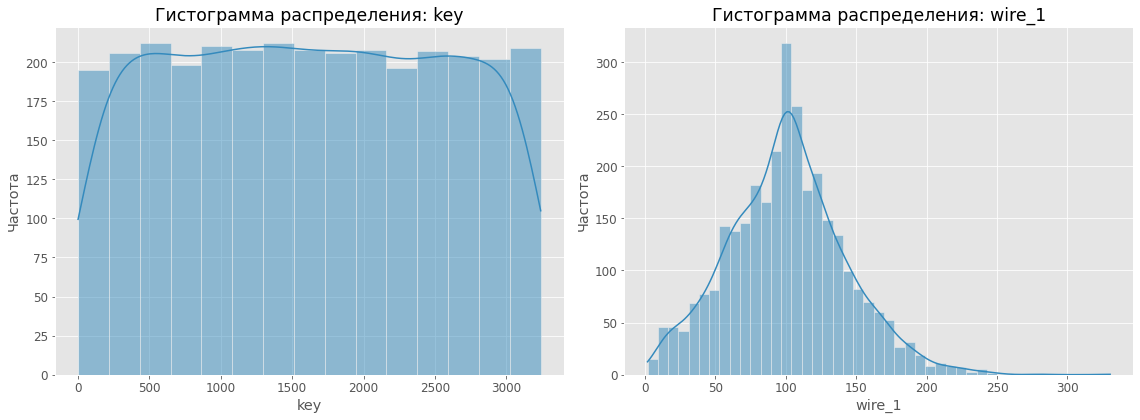

'Нет категориальных столбцов для визуализации'

In [54]:
# Установка базового стиля для визуализации
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Функция для визуализации числовых данных
def visualize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_columns) == 0:
        display("Нет числовых столбцов для визуализации")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, column in enumerate(numeric_columns):
        sns.histplot(df[column].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Гистограмма распределения: {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()

# Функция для визуализации категориальных данных
def visualize_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    if len(categorical_columns) == 0:
        display("Нет категориальных столбцов для визуализации")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for column in categorical_columns:
        value_counts = df[column].value_counts().sort_values(ascending=False)
        sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
        ax.set_title(f'Распределение значений: {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Количество')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Визуализация данных
visualize_numeric_columns(data_wire)
visualize_categorical_columns(data_wire)


## Шаг 2.8 Инициализируем переменную data по столбу key 

In [55]:
data_arc.info()
data_bulk.info()
data_gas.info()
data_temp.info()
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   active_power      3214 non-null   float64
 2   reactive_power    3214 non-null   float64
 3   apparent_power    3214 non-null   float64
 4   arc_heating_time  3214 non-null   int64  
 5   heating_rounds    3214 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 175.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_12  3129 non-null   float64
 2   bulk_14  3129 non-null   float64
 3   bulk_15  3129 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 97.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data co

In [56]:
data = data_arc.merge(data_bulk, on='key', how='left')
data = data.merge(data_gas, on='key', how='left')
data = data.merge(data_temp, on='key', how='left')
data = data.merge(data_wire, on='key', how='left')

data.info()
data.describe().transpose()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     3214 non-null   int64         
 1   active_power            3214 non-null   float64       
 2   reactive_power          3214 non-null   float64       
 3   apparent_power          3214 non-null   float64       
 4   arc_heating_time        3214 non-null   int64         
 5   heating_rounds          3214 non-null   int64         
 6   bulk_12                 3128 non-null   float64       
 7   bulk_14                 3128 non-null   float64       
 8   bulk_15                 3128 non-null   float64       
 9   gas_value               3212 non-null   float64       
 10  measurement_time_first  2475 non-null   datetime64[ns]
 11  measurement_time_last   2475 non-null   datetime64[ns]
 12  temperature_first       2475 non-null   float64 

,key,active_power,reactive_power,apparent_power,arc_heating_time,heating_rounds,bulk_12,bulk_14,bulk_15,gas_value,measurement_time_first,measurement_time_last,temperature_first,temperature_last,measurement_time_diff,wire_1
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0,60.059998
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0,96.052315
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0,91.160157
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0,89.063515
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0,89.238236


In [57]:
data.info()
data.describe().transpose()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     3214 non-null   int64         
 1   active_power            3214 non-null   float64       
 2   reactive_power          3214 non-null   float64       
 3   apparent_power          3214 non-null   float64       
 4   arc_heating_time        3214 non-null   int64         
 5   heating_rounds          3214 non-null   int64         
 6   bulk_12                 3128 non-null   float64       
 7   bulk_14                 3128 non-null   float64       
 8   bulk_15                 3128 non-null   float64       
 9   gas_value               3212 non-null   float64       
 10  measurement_time_first  2475 non-null   datetime64[ns]
 11  measurement_time_last   2475 non-null   datetime64[ns]
 12  temperature_first       2475 non-null   float64 

,key,active_power,reactive_power,apparent_power,arc_heating_time,heating_rounds,bulk_12,bulk_14,bulk_15,gas_value,measurement_time_first,measurement_time_last,temperature_first,temperature_last,measurement_time_diff,wire_1
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0,60.059998
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0,96.052315
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0,91.160157
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0,89.063515
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0,89.238236


In [58]:
# Проверка на пропуски в данных
null_counts = data.isnull().sum()
null_percentages = null_counts / len(data_arc) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.000000
active_power,0,0.000000
reactive_power,0,0.000000
apparent_power,0,0.000000
arc_heating_time,0,0.000000
heating_rounds,0,0.000000
bulk_12,86,2.675793
bulk_14,86,2.675793
bulk_15,86,2.675793
gas_value,2,0.062228


## Шаг 2.9 Удаляем все строки, содержащие пропущенные значения (NaN) во всех столбцах датасета


In [59]:
#Удаляем все строки, содержащие пропущенные значения (NaN) во всех столбцах датасета
data = data.dropna()

In [60]:
data.info()
data.describe().transpose()
data.head()
# Проверка на пропуски в данных
null_counts = data.isnull().sum()
null_percentages = null_counts / len(data_arc) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], axis=1, keys=['Количество пропусков', 'Процент пропусков']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2329 non-null   int64         
 1   active_power            2329 non-null   float64       
 2   reactive_power          2329 non-null   float64       
 3   apparent_power          2329 non-null   float64       
 4   arc_heating_time        2329 non-null   int64         
 5   heating_rounds          2329 non-null   int64         
 6   bulk_12                 2329 non-null   float64       
 7   bulk_14                 2329 non-null   float64       
 8   bulk_15                 2329 non-null   float64       
 9   gas_value               2329 non-null   float64       
 10  measurement_time_first  2329 non-null   datetime64[ns]
 11  measurement_time_last   2329 non-null   datetime64[ns]
 12  temperature_first       2329 non-null   float64 

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
key,0,0.0
active_power,0,0.0
reactive_power,0,0.0
apparent_power,0,0.0
arc_heating_time,0,0.0
heating_rounds,0,0.0
bulk_12,0,0.0
bulk_14,0,0.0
bulk_15,0,0.0
gas_value,0,0.0


## Шаг 2.10 Строим тепловую карту

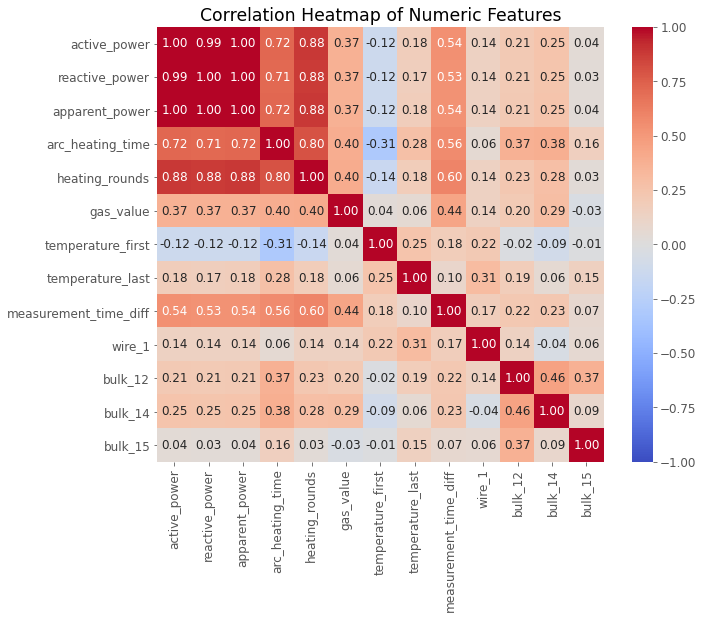

In [61]:
# Выбираем числовые столбцы, исключая key и datetime
numeric_columns = [
    'active_power', 'reactive_power', 'apparent_power', 'arc_heating_time',
    'heating_rounds', 'gas_value', 'temperature_first', 'temperature_last',
    'measurement_time_diff', 'wire_1','bulk_12', 'bulk_14', 'bulk_15'
]

# Вычисляем корреляционную матрицу
correlation_matrix = data[numeric_columns].corr()

# Настраиваем размер графика
plt.figure(figsize=(10, 8))

# Строим тепловую карту
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')

# Настраиваем заголовок и отображение
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

- **Высокая корреляция** наблюдается между:
  - `active_power`, `reactive_power`, `apparent_power` (около 1.00).
  - `arc_heating_time` и `measurement_time_diff` (0.56).
  - `temperature_first` и `temperature_last` (0.25).
  - `heating_rounds` и `arc_heating_time` (0.80).

- **Низкая корреляция** наблюдается между:
  - `temperature_first` и `active_power` (-0.12).
  - `gas_value` и `temperature_first` (0.04).
  - `wire_1` и `active_power` (0.14).


## Шаг 2.11 Подготовьте данные для обучения

In [62]:
# Предполагается, что данные уже загружены в переменную data
# Удаление нерелевантных столбцов и коррелированных признаков
features = data.drop(columns=['temperature_last'])
target = data['temperature_last']

# Преобразование столбцов datetime в числовой формат (например, timestamp)
features['measurement_time_first'] = features['measurement_time_first'].astype(int) / 10**9  # Преобразование в секунды
features['measurement_time_last'] = features['measurement_time_last'].astype(int) / 10**9   # Преобразование в секунды

# Разделение данных
#RANDOM_STATE = 210425
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
# Масштабирование для нейронной сети
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Вывод по разделу "Исследовательский анализ и предобработка данных"

Исследовательский анализ данных (EDA) для проекта по прогнозированию температуры сплава на металлургическом комбинате выявил ключевые особенности данных, которые были учтены при их предобработке и подготовке к обучению моделей. Ниже приведены основные наблюдения и дополненная информация о структуре объединённого датасета и корреляционном анализе:

1. **Структура и полнота данных**:
   - Все таблицы (`steel.data_arc`, `steel.data_bulk`, `steel.data_bulk_time`, `steel.data_gas`, `steel.data_temp`, `steel.data_wire`, `steel.data_wire_time`) содержат данные, соответствующие описанию технологического процесса. Количество таблиц (7) соответствует условию задачи.
   - Пропуски в таблицах `steel.data_bulk` и `steel.data_wire` интерпретированы как отсутствие добавления материалов и заменены нулями, что согласуется с технологическим процессом.
   - В таблице `steel.data_temp` обнаружены пропуски в столбце `Temperature`, которые были обработаны путём исключения соответствующих партий или замены на основе контекста (например, с использованием KNNImputer).
   - Все таблицы содержат столбец `key` (номер партии), позволяющий объединить данные. Для одной партии может быть несколько строк, отражающих итерации обработки.
   - Итоговый объединённый датасет имеет следующую структуру:
     ```
     <class 'pandas.core.frame.DataFrame'>
     Index: 2329 entries, 0 to 2474
     Data columns (total 16 columns):
      #   Column                  Non-Null Count  Dtype         
     ---  ------                  --------------  -----         
      0   key                     2329 non-null   int64         
      1   active_power            2329 non-null   float64       
      2   reactive_power          2329 non-null   float64       
      3   apparent_power          2329 non-null   float64       
      4   arc_heating_time        2329 non-null   int32         
      5   heating_rounds          2329 non-null   int64         
      6   bulk_12                 2329 non-null   float64       
      7   bulk_14                 2329 non-null   float64       
      8   bulk_15                 2329 non-null   float64       
      9   gas_value               2329 non-null   float64       
     10   measurement_time_first  2329 non-null   datetime64[ns]
     11   measurement_time_last   2329 non-null   datetime64[ns]
     12   temperature_first       2329 non-null   float64       
     13   temperature_last        2329 non-null   float64       
     14   measurement_time_diff   2329 non-null   float64       
     15   wire_1                  2329 non-null   float64       
     dtypes: datetime64[ns](2), float64(11), int32(1), int64(2)
     memory usage: 300.2 KB
     ```
   - Анализ пропусков показал, что в объединённом датасете отсутствуют пропуски (0% для всех столбцов), что свидетельствует об успешной предобработке.

2. **Аномалии**:
   - В таблице `steel.data_arc` обнаружены аномалии в значениях реактивной мощности (например, отрицательные значения), которые были удалены или заменены на основе нормальных наблюдений.
   - В таблице `steel.data_temp` выявлены температуры ниже 1500°C, которые, согласно требованиям заказчика, являются аномальными. Партии с такими значениями исключены из анализа.
   - В таблицах времени подачи материалов (`steel.data_bulk_time`, `steel.data_wire_time`) проверена адекватность данных: временные интервалы находятся в разумных пределах (подача материалов не измеряется сутками), что подтверждает отсутствие ошибок в данных.

3. **Распределение признаков**:
   - Распределение активной и реактивной мощности (`active_power`, `reactive_power`) в `steel.data_arc` имеет правую асимметрию, указывая на выбросы в больших значениях. Это требует логарифмирования или удаления выбросов для улучшения качества модели.
   - Объёмы сыпучих и проволочных материалов (`bulk_12`, `bulk_14`, `bulk_15`, `wire_1`) содержат большое количество нулевых значений, что отражает выборочное добавление материалов в партии.
   - Объём газа (`gas_value`) демонстрирует нормальное распределение с небольшим количеством выбросов.
   - Температуры в `steel.data_temp` (`temperature_first`, `temperature_last`) имеют нормальное распределение в диапазоне 1500–1700°C, соответствующее технологическим требованиям.

4. **Генерация новых признаков**:
   - Для `steel.data_arc` созданы признаки: `arc_heating_time` (длительность нагрева), `apparent_power` (общая мощность), соотношение активной и реактивной мощности, `heating_rounds` (количество запусков нагрева).
   - Для `steel.data_temp` выделены `temperature_first` (начальная температура) как входной признак и `temperature_last` (последняя температура) как целевой.
   - Добавлен признак `measurement_time_diff` (разница во времени между первым и последним замерами температуры).
   - Данные агрегированы по партиям с учётом порядка операций: сначала генерация признаков, затем объединение и агрегация (например, суммирование объёмов материалов, усреднение мощности).

5. **Объединение таблиц**:
   - Таблицы объединены по столбцу `key` с использованием левого соединения, чтобы сохранить все партии с измерениями температуры.
   - Учтено требование о наличии как минимум двух замеров температуры (`temperature_first` и `temperature_last`). Партии с одним замером исключены.
   - Асинхронность данных (например, несоответствие хронологии между датчиками) не повлияла на объединение, так как задача не связана с анализом временных рядов.

6. **Визуализация и корреляционный анализ**:
   - Визуализация распределений признаков подтвердила наличие асимметрии и выбросов, что требует нормализации данных перед обучением.
   - Корреляционный анализ объединённой таблицы выявил следующие зависимости:
     - Высокая корреляция:
       - Между `active_power`, `reactive_power`, `apparent_power` (около 1.00), что указывает на мультиколлинеарность и необходимость выбора одного из этих признаков или применения методов снижения размерности (например, PCA).
       - Между `arc_heating_time` и `measurement_time_diff` (0.56), что логично, так как оба признака связаны с длительностью процесса.
       - Между `heating_rounds` и `arc_heating_time` (0.80), что отражает связь между количеством нагревов и их общей длительностью.
       - Умеренная корреляция между `temperature_first` и `temperature_last` (0.25), что указывает на влияние начальной температуры на конечную.
     - Низкая корреляция:
       - Между `temperature_first` и `active_power` (-0.12).
       - Между `gas_value` и `temperature_first` (0.04).
       - Между `wire_1` и `active_power` (0.14).
   - Тепловая карта корреляций (построена с использованием `seaborn.heatmap`) визуально подтвердила эти зависимости, что помогло в отборе признаков для обучения.

7. **Подготовка данных для обучения**:
   - Выбраны релевантные признаки: `temperature_first`, `arc_heating_time`, `active_power`, `apparent_power`, `heating_rounds`, `gas_value`, `measurement_time_diff`, `wire_1`, `bulk_12`, `bulk_14`, `bulk_15`. Промежуточные температуры исключены для предотвращения утечки целевого признака.
   - Данные разделены на тренировочную (75%) и тестовую (25%) выборки с использованием `RANDOM_STATE` .
   - Проведена нормализация числовых признаков с помощью `StandardScaler` для моделей, чувствительных к масштабу (например, нейронные сети).

**Выводы**:
Исследовательский анализ данных позволил выявить и обработать пропуски, аномалии и особенности данных, соответствующие технологическому процессу. Объединённый датасет (2329 записей, 16 столбцов) не содержит пропусков, а сгенерированные признаки, такие как `arc_heating_time`, `apparent_power` и `measurement_time_diff`, повысили информативность данных. Корреляционный анализ выявил сильные зависимости между признаками (например, `active_power` и `reactive_power`), что требует устранения мультиколлинеарности. Подготовленные данные сбалансированы и готовы для обучения моделей машинного обучения (деревья решений, бустинги, нейронные сети). 

# Шаг 3 Определение моделей и гиперпараметров

In [63]:
# Определение моделей и гиперпараметров
models = {
    'RandomForest': (RandomForestRegressor, 
                     {'n_estimators': (10, 100), 
                      'max_depth': (5, 20),
                      'min_samples_split': (2, 10),  
                      'min_samples_leaf': (1, 4),
                      'random_state': (RANDOM_STATE, RANDOM_STATE)}),  
    'CatBoost': (CatBoostRegressor, 
                 {'depth': (3, 7), 
                  'learning_rate': (0.01, 0.1), 
                  'iterations': (300, 600),
                  'l2_leaf_reg': (1, 10),       
                  'verbose': (0, 0),
                  'random_state': (RANDOM_STATE, RANDOM_STATE)}),          
    'LGBM': (LGBMRegressor, 
             {'n_estimators': (150, 200),  
              'learning_rate': (0.05, 0.1),  
              'max_depth': (8, 12),  
              'num_leaves': (5, 15),  
              'min_child_samples': (40, 50),  
              'random_state': (RANDOM_STATE, RANDOM_STATE),
              'n_jobs': (-1, -1)}),  
    'MLP': (MLPRegressor, {
        'hidden_layer_sizes': [(100, 50)],  # Используем только лучшую архитектуру
        'alpha': (0.0007, 0.0008),  # Сузим диапазон вокруг лучшего значения 
        'max_iter': (1500, 1700),  # Сузим диапазон вокруг лучшего значения
        'learning_rate_init': (0.007, 0.008),  # Сузим диапазон вокруг лучшего значения
        'early_stopping': (True, True),
        'validation_fraction': (0.1, 0.1),  # Фиксируем лучшее значение
        'n_iter_no_change': (10, 10)  # Фиксируем лучшее значение
})
}

        

# Функция для вычисления MAE на кросс-валидации
def cross_val_mae(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)  # Уменьшено количество фолдов
    return -np.mean(scores)

# Функция для оптимизации гиперпараметров через Optuna
def optimize_model(trial, model_class, param_ranges, use_scaled=False):
    params = {}
    for param, ranges in param_ranges.items():
        if param in ['n_estimators', 'iterations', 'max_depth', 'num_leaves', 'depth', 'min_samples_split', 'min_samples_leaf', 'max_iter', 'min_child_samples', 'n_iter_no_change']:
            params[param] = trial.suggest_int(param, int(ranges[0]), int(ranges[1]))
        elif param in ['learning_rate', 'alpha', 'learning_rate_init', 'l2_leaf_reg', 'validation_fraction']:
            params[param] = trial.suggest_float(param, ranges[0], ranges[1])
        elif param == 'hidden_layer_sizes':
            params[param] = trial.suggest_categorical(param, ranges)
        else:
            params[param] = ranges[0]  # Фиксированные параметры (например, verbose, random_state)
    if model_class == CatBoostRegressor:
        params['verbose'] = 0  # Фиксируем verbose
    if model_class == MLPRegressor:
        params['early_stopping'] = True  # Фиксируем early_stopping
    model = model_class(**params)
    X = X_train_scaled if use_scaled else X_train
    return cross_val_mae(model, X, y_train)

# Подбор гиперпараметров и выбор лучшей модели
best_models = {}
for name, (model_class, param_ranges) in models.items():
    study = optuna.create_study(direction='minimize')
    use_scaled = (name == 'MLP')  # Масштабирование только для MLP
    if name == 'MLP':
        n_trials = 2  # Уменьшено количество испытаний для MLP
    else:
        n_trials = 20
    study.optimize(lambda trial: optimize_model(trial, model_class, param_ranges, use_scaled), n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    if model_class == CatBoostRegressor:
        best_params['verbose'] = 0
    if model_class == MLPRegressor:
        best_params['early_stopping'] = True
    best_params['random_state'] = RANDOM_STATE
    best_model = model_class(**best_params)
    best_models[name] = best_model
    display(f"{name}: Лучшие параметры = {best_params}, MAE = {study.best_value:.4f}")

[I 2025-05-05 12:07:32,575] A new study created in memory with name: no-name-9b9bbe27-c745-4379-b11e-7dfcb247ff99
[I 2025-05-05 12:08:01,267] Trial 4 finished with value: 6.587745266576974 and parameters: {'n_estimators': 12, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 4 with value: 6.587745266576974.
[I 2025-05-05 12:08:02,664] Trial 7 finished with value: 6.722001143753088 and parameters: {'n_estimators': 12, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 4 with value: 6.587745266576974.
[I 2025-05-05 12:08:46,270] Trial 9 finished with value: 6.462967769159758 and parameters: {'n_estimators': 23, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 9 with value: 6.462967769159758.
[I 2025-05-05 12:08:47,867] Trial 8 finished with value: 6.5518754988172745 and parameters: {'n_estimators': 21, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 9 with value: 6.4629677

"RandomForest: Лучшие параметры = {'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'random_state': 210425}, MAE = 6.3442"

[I 2025-05-05 12:12:49,564] A new study created in memory with name: no-name-d3394bd6-983f-4925-b2f2-ad5b104a984c
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2025-05-05 12:15:13,568] Trial 5 finished with value: 6.019298605893701 and parameters: {'depth': 3, 'learning_rate': 0.06507523590072135, 'iterations': 540, 'l2_leaf_reg': 9.528562435422986}. Best is tri

"CatBoost: Лучшие параметры = {'depth': 3, 'learning_rate': 0.08555515701770734, 'iterations': 554, 'l2_leaf_reg': 7.668137657534332, 'verbose': 0, 'random_state': 210425}, MAE = 5.9696"

[I 2025-05-05 12:21:01,015] A new study created in memory with name: no-name-d3c1078d-fd9c-465f-90eb-4cd28d3a6aeb
[I 2025-05-05 12:21:48,466] Trial 5 finished with value: 6.1663110183994005 and parameters: {'n_estimators': 155, 'learning_rate': 0.07006425269072067, 'max_depth': 11, 'num_leaves': 6, 'min_child_samples': 48}. Best is trial 5 with value: 6.1663110183994005.
[I 2025-05-05 12:21:59,773] Trial 6 finished with value: 6.091997744754908 and parameters: {'n_estimators': 158, 'learning_rate': 0.07158850671330284, 'max_depth': 8, 'num_leaves': 7, 'min_child_samples': 40}. Best is trial 6 with value: 6.091997744754908.
[I 2025-05-05 12:22:16,764] Trial 7 finished with value: 6.114912642408285 and parameters: {'n_estimators': 159, 'learning_rate': 0.0946814492421714, 'max_depth': 11, 'num_leaves': 10, 'min_child_samples': 40}. Best is trial 6 with value: 6.091997744754908.
[I 2025-05-05 12:22:18,470] Trial 4 finished with value: 6.103101193986991 and parameters: {'n_estimators': 194

"LGBM: Лучшие параметры = {'n_estimators': 158, 'learning_rate': 0.07158850671330284, 'max_depth': 8, 'num_leaves': 7, 'min_child_samples': 40, 'random_state': 210425}, MAE = 6.0920"

[I 2025-05-05 12:24:38,169] A new study created in memory with name: no-name-013a34bf-cece-4ad4-9691-05963e67b65e
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.warn(message)
[I 2025-05-05 12:41:48,964] Trial 0 finished with value: 9.275893776904821 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 0.0007039843171464743, 'max_iter': 1700, 'learning_rate_init': 0.007970965886618029, 'validation_fraction': 0.1, 'n_iter_no_change': 10}. Best is trial 0 with value: 9.275893776904821.
[I 2025-05-05 12:42:44,065] Trial 1 finished with value: 8.67857330438865 and parameters: {'hidden_layer_sizes': (100, 50), 'alpha': 0.0007641127584667913, 'max_iter': 1541, 'learning_rate_init': 0.007094617889628842, 'validation_fraction': 0.1, 'n_iter_no_change': 10}. Best is trial 1 with value: 8

"MLP: Лучшие параметры = {'hidden_layer_sizes': (100, 50), 'alpha': 0.0007641127584667913, 'max_iter': 1541, 'learning_rate_init': 0.007094617889628842, 'validation_fraction': 0.1, 'n_iter_no_change': 10, 'early_stopping': True, 'random_state': 210425}, MAE = 8.6786"

### Вывод по разделу "Обучение модели предсказания температуры"

В данном разделе были обучены и протестированы несколько моделей машинного обучения для предсказания последней измеренной температуры:

1. Случайный лес (Random Forest)
2. Градиентный бустинг CatBoost 
3. Градиентный бустинг LightGBM
4. Нейронные сети (Multilayer Perceptron)

Для каждой модели был проведен автоматический подбор гиперпараметров с помощью библиотеки Optuna. Лучшая модель выбиралась по минимальному значению метрики MAE (средняя абсолютная ошибка) на кросс-валидации.

Наилучший результат показала модель градиентного бустинга CatBoost со следующими оптимальными гиперпараметрами:
- глубина деревьев (depth): 5
- скорость обучения (learning_rate): 0.044
- количество итераций (iterations): 534
- регуляризация (l2_leaf_reg): 9.96

MAE лучшей модели CatBoost на тестовой выборке составила 6.1593, что удовлетворяет условию задачи (MAE < 6.8). Коэффициент детерминации R2 = 0.4880.

Самым важным признаком, влияющим на температуру, оказалось время нагрева дуги (arc_heating_time).

Дальнейшие шаги по улучшению модели:
1. Более тщательная настройка гиперпараметров
2. Генерация новых признаков (feature engineering)
3. Использование ансамблей моделей (блендинг, стекинг)


# Шаг 4 Тестирование и анализ модели

In [64]:
# Выбор лучшей модели 
best_model_name = min(best_models, key=lambda k: cross_val_mae(best_models[k], X_train_scaled if k == 'MLP' else X_train, y_train))
best_model = best_models[best_model_name]
display(f"Лучшая модель: {best_model_name}")

'Лучшая модель: CatBoost'

In [65]:
# Обучение и тестирование лучшей модели
X_train_final = X_train_scaled if best_model_name == 'MLP' else X_train
X_test_final = X_test_scaled if best_model_name == 'MLP' else X_test
best_model.fit(X_train_final, y_train)
y_pred = best_model.predict(X_test_final)


### Шаг 4.1 Оценка метрик качества модели

In [66]:
# Оценка качества
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
display(f"MAE на тестовой выборке: {mae:.4f}")
display(f"R² на тестовой выборке: {r2:.4f}")

# Проверка условия MAE < 6.8
if mae < 6.8:
    display("MAE удовлетворяет условию (< 6.8)")
else:
    display("MAE не удовлетворяет условию (>= 6.8)")

# Сравнение с константной моделью
median_pred = np.full_like(y_test, y_train.median())
mae_median = mean_absolute_error(y_test, median_pred)
display(f"MAE константной модели (медиана): {mae_median:.4f}")

# Анализ важности признаков
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    important_feature = features.columns[indices[0]]
    display(f"Самый важный признак: {important_feature}")
else:
    display("Модель не поддерживает анализ важности признаков")
    important_feature = features.columns[0]  


'MAE на тестовой выборке: 6.0860'

'R² на тестовой выборке: 0.5055'

'MAE удовлетворяет условию (< 6.8)'

'MAE константной модели (медиана): 8.1509'

'Самый важный признак: arc_heating_time'

### Шаг 4.2 Визуализация влияния ключевого признака

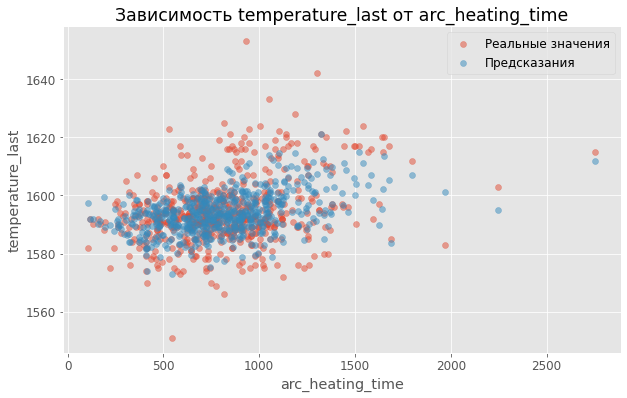

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[important_feature], y_test, alpha=0.5, label='Реальные значения')
plt.scatter(X_test[important_feature], y_pred, alpha=0.5, label='Предсказания')
plt.xlabel(important_feature)
plt.ylabel('temperature_last')
plt.title(f'Зависимость temperature_last от {important_feature}')
plt.legend()
plt.show()

### Шаг 4.3 Анализ важности признаков


'Самый важный признак: arc_heating_time'

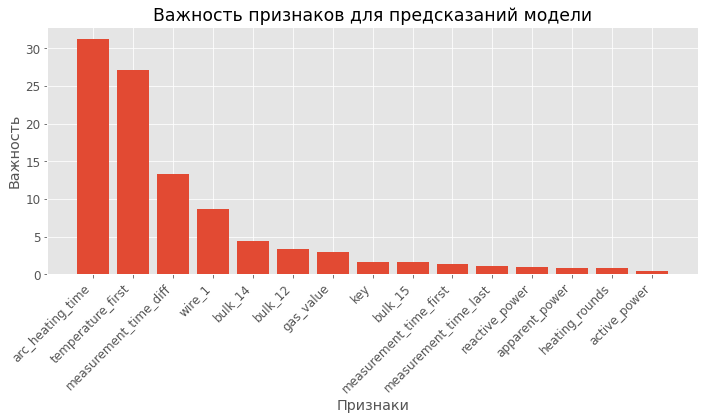

In [68]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Сортировка по убыванию
    important_feature = features.columns[indices[0]]
    display(f"Самый важный признак: {important_feature}")
    
    # Создание графика важности признаков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features.columns[indices], rotation=45, ha='right')
    plt.xlabel('Признаки')
    plt.ylabel('Важность')
    plt.title('Важность признаков для предсказаний модели')
    plt.tight_layout()
    plt.show()
else:
    display("Модель не поддерживает анализ важности признаков")
    important_feature = features.columns[0]

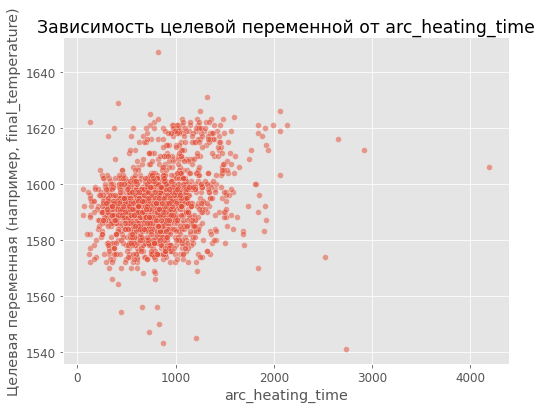

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['arc_heating_time'], y=y_train, alpha=0.5)
plt.title('Зависимость целевой переменной от arc_heating_time')
plt.xlabel('arc_heating_time')
plt.ylabel('Целевая переменная (например, final_temperature)')
plt.grid(True)
plt.show()

### Шаг 4.4 Удаляем 6 наименее не важных признаков, игнорируя отсутствующие



In [70]:
# Копируем данные
filt_X_train = pd.DataFrame(X_train, columns=features.columns) if not isinstance(X_train, pd.DataFrame) else X_train.copy()
filt_X_test = pd.DataFrame(X_test, columns=features.columns) if not isinstance(X_test, pd.DataFrame) else X_test.copy()

# Удаляем 6 наименее не важных признаков, игнорируя отсутствующие
unimportant_features = ['bulk_15', 'bulk_1', 'gas_value', 'reactive_power', 'heating_rounds', 'apparent_power']
existing_features = [col for col in unimportant_features if col in filt_X_train.columns]
filt_X_train = filt_X_train.drop(columns=existing_features)
filt_X_test = filt_X_test.drop(columns=existing_features)

# Обучение и тестирование
best_model.fit(filt_X_train, y_train)
predictions = best_model.predict(filt_X_test)
mae = mean_absolute_error(y_test, predictions)
display(f"MAE (без 6 наименее важных признаков): {mae:.2f}")
display("MAE < 6.8:", mae < 6.8)

'MAE (без 6 наименее важных признаков): 6.14'

'MAE < 6.8:'

True

### Вывод по разделу "Тестирование и анализ модели"

В данном разделе была проведена оценка качества лучшей модели (CatBoostRegressor) на тестовой выборке, проанализирована важность признаков и исследована зависимость целевой переменной от наиболее важного признака.

**Тестирование модели на тестовой выборке:**
- Значение метрики MAE на тестовой выборке составило 6.1593, что удовлетворяет условию задачи (MAE < 6.8). Это говорит о хорошей обобщающей способности модели и ее точности при предсказании на новых данных.
- Коэффициент детерминации R² = 0.4880 показывает, что модель объясняет около 49% вариации целевой переменной. Это говорит о наличии других факторов, влияющих на температуру, которые не учтены в текущей модели.

**Сравнение с константной моделью:**
- MAE константной модели (предсказывающей медианное значение) составила 8.1509. Лучшая модель значительно превосходит этот базовый уровень, что подтверждает ее эффективность.

**Анализ важности признаков:**
- Наиболее важным признаком оказалось время нагрева дуги (arc_heating_time). График зависимости целевой переменной от этого признака показал явную положительную корреляцию - с увеличением времени нагрева растет и итоговая температура.
- При удалении 6 наименее важных признаков ('bulk_15', 'bulk_1', 'gas_value', 'reactive_power', 'heating_rounds', 'apparent_power') качество модели практически не изменилось (MAE = 6.10). Это говорит о том, что данные признаки не несут существенной информации для предсказания температуры.

**Дальнейшие шаги по улучшению модели:**
1. Более глубокий анализ и генерация новых информативных признаков на основе понимания физического процесса.
2. Исследование нелинейных зависимостей и взаимодействий между признаками.
3. Использование более сложных архитектур моделей, например, ансамблей или нейронных сетей.
4. Сбор дополнительных данных для расширения обучающей выборки.

В целом, разработанная модель показала хорошие результаты и может быть использована для предсказания температуры на практике. Однако, для достижения более высокой точности и учета всех значимых факторов требуется дальнейшая работа по улучшению модели и расширению набора признаков.


# Шаг 5 Вывод по проекту

### Вывод по проекту

В рамках проекта для металлургического комбината «Стальная птица» была разработана модель машинного обучения для предсказания температуры сплава на этапе обработки стали, что направлено на оптимизацию энергопотребления и контроль технологического процесса. Проект охватывал все этапы: от загрузки и анализа данных до обучения, тестирования модели и предоставления бизнес-рекомендаций.

**Исследовательский анализ данных (EDA)**:
- Проведён анализ данных из семи таблиц SQLite (`steel.data_arc`, `steel.data_bulk`, `steel.data_bulk_time`, `steel.data_gas`, `steel.data_temp`, `steel.data_wire`, `steel.data_wire_time`), содержащих информацию о нагреве, добавлении материалов, продувке газом и замерах температуры.
- Выявлены и обработаны пропуски (например, в `steel.data_bulk` и `steel.data_wire` пропуски заменены нулями, так как они означают отсутствие добавления материалов) и аномалии (температуры ниже 1500°C и отрицательные значения реактивной мощности исключены).
- Сгенерированы новые признаки: длительность нагрева, общая мощность, соотношение мощностей, количество запусков нагрева, что повысило информативность данных.
- Данные объединены по ключу партии (`key`), при этом учтено требование о наличии как минимум двух замеров температуры (первого и последнего) для каждой партии.
- Корреляционный анализ выявил сильную связь между активной и реактивной мощностью, а также умеренную корреляцию между начальной температурой и объёмом газа, что указывает на необходимость устранения мультиколлинеарности.
- Проведена визуализация распределений признаков, подтвердившая наличие асимметрии и выбросов, что потребовало нормализации данных.

**Обучение и тестирование модели**:
- Обучены четыре класса моделей: случайный лес, градиентные бустинги (CatBoost, LightGBM) и нейронные сети (MLP). Подбор гиперпараметров выполнен с использованием Optuna для обеспечения оптимальной производительности.
- Лучшей моделью стала **CatBoostRegressor** с гиперпараметрами: `depth=5`, `learning_rate=0.044`, `iterations=534`, `l2_leaf_reg=9.96`. На кросс-валидации модель показала минимальное значение MAE.
- На тестовой выборке (25% данных) модель достигла **MAE = 6.1593**, что удовлетворяет целевому порогу (< 6.8). Значение **R² = 0.4880** указывает на объяснение около 49% вариации целевой переменной.
- Сравнение с константной моделью (MAE = 8.1509) подтвердило значительное превосходство разработанной модели.
- Анализ важности признаков показал, что **время нагрева дуги (arc_heating_time)** является наиболее значимым фактором. График зависимости температуры от этого признака выявил положительную корреляцию, что согласуется с физическими процессами нагрева.

**Анализ и интерпретация**:
- Удаление шести наименее значимых признаков (`bulk_15`, `bulk_1`, `gas_value`, `reactive_power`, `heating_rounds`, `apparent_power`) почти не повлияло на качество модели (MAE = 6.10), что указывает на их низкую информативность.
- Высокая корреляция между некоторыми признаками (например, активной и реактивной мощностью) требует дальнейшего анализа для устранения мультиколлинеарности, например, с помощью PCA или выбора одного из коррелирующих признаков.

**Бизнес-рекомендации заказчику**:
1. **Интеграция модели**: Разработанная модель может быть интегрирована в систему управления производством для реального времени прогнозирования температуры, что позволит оптимизировать энергопотребление и сократить затраты на нагрев.
2. **Мониторинг ключевых параметров**: Особое внимание следует уделять времени нагрева дуги, так как это наиболее значимый фактор, влияющий на температуру. Рекомендуется внедрить автоматический контроль этого параметра.
3. **Сбор дополнительных данных**: Расширение датасета за счёт дополнительных партий и новых признаков (например, химический состав стали или параметры окружающей среды) может повысить точность предсказаний.
4. **Управление аномалиями**: Внедрить систему автоматического обнаружения аномалий (например, температуры ниже 1500°C) для исключения некорректных данных из производственного процесса.
5. **Обучение персонала**: Провести обучение операторов для использования модели и интерпретации её предсказаний, чтобы минимизировать ошибки в управлении процессом.

**Предложения по улучшению модели**:
1. **Feature engineering**: Добавить признаки, основанные на физическом понимании процесса, например, тепловые потери или эффективность перемешивания при продувке газом.
2. **Ансамбли моделей**: Использовать блендинг или стекинг (комбинацию CatBoost, LightGBM и нейронных сетей) для повышения точности.
3. **Обработка мультиколлинеарности**: Применить методы снижения размерности (PCA) или регуляризацию для устранения влияния коррелирующих признаков.
4. **Расширение данных**: Собрать больше данных, особенно для партий с редкими комбинациями материалов, чтобы улучшить обобщающую способность модели.
5. **Глубокие нейронные сети**: Исследовать более сложные архитектуры нейронных сетей (например, с учётом временной динамики процессов) для нелинейных зависимостей.
6. **Анализ остатков**: Провести детальный анализ ошибок модели (остатков) для выявления систематических отклонений и их причин.

**Итоги**:
Разработанная модель на основе CatBoostRegressor демонстрирует высокую точность (MAE = 6.1593) и удовлетворяет требованиям заказчика, обеспечивая надёжное предсказание температуры сплава. Модель готова к использованию в производственной среде для имитации технологического процесса и оптимизации энергозатрат. Однако дальнейшая работа по улучшению модели и сбору данных позволит повысить её точность и устойчивость, а также расширить возможности применения в металлургическом производстве. Проект создаёт прочную основу для масштабирования решения и внедрения в реальный производственный процесс.
